In [75]:
import re
from pathlib import Path
from itertools import combinations
import numpy as np
import pandas as pd
import pyrepseq as prs
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

In [76]:
# Setting paths
data_dir = Path("../Data/20250903 Comparison 1")
output_dir = Path("Final_Figures_and_Sheets_Singleset")
output_dir.mkdir(exist_ok=True)

In [77]:
# Confirming epitope-MHC mapping
MHC_MAP = {
    "RTY": "Kb",
    "SNY": "Kb",
    "VGP": "Kb",
    "GYF": "Kd",
    "HFL": "Kd",
    "SYF": "Kd",
}

# Strictness groupers for combined Kb+Kd analysis
STRICTNESS_GROUPERS = {
    "MouseID": ["SampleTitle"],
    "GraftID": ["DonorStrain", "RecipientStrain"],
    "MHC+Epitope": ["MHC", "Epitope"],
    "Epitope": ["Epitope"],
    "Recipient": ["RecipientStrain"],
    "Donor": ["DonorStrain"],
    "MHC": ["MHC"],
}

In [78]:
# Loading files - all Rhapsody CSVs and Sanger Excel
samples = {
    # Sanger data
    "Sanger Data": data_dir / "20250908 Epitope specific TCR LL Sanger.xlsx",
    
    # SYF - Balbc → B10BR (HTx)
    "Balbc-B10BR HTxA Kd-SYF HIL": data_dir / "20250902 Balbc-B10 HTxA SYF HIL TCR Repertoire.csv",
    "Balbc-B10BR HTxB Kd-SYF HIL": data_dir / "20250902 Balbc-B10 HTxB SYF HIL TCR Repertoire.csv",
    "Balbc-B10BR HTxC Kd-SYF HIL": data_dir / "20250902 Balbc-B10 HTxC SYF HIL TCR Repertoire.csv",
    
    # SYF - B6Kd → C57BL6 (SkTx)
    "B6Kd-C57BL6 SkTxA Kd-SYF LL": data_dir / "20250903 B6Kd-BL6 SkTxA SYF LL TCR Repertoire.csv",
    "B6Kd-C57BL6 SkTxB Kd-SYF LL": data_dir / "20250903 B6Kd-BL6 SkTxB SYF LL TCR Repertoire.csv",
    "B6Kd-C57BL6 SkTxC Kd-SYF LL": data_dir / "20250903 B6Kd-BL6 SkTxC SYF LL TCR Repertoire.csv",
    
    # GYF - B6Kd → C57BL6 (SkTx)
    "B6Kd-C57BL6 SkTxD Kd-GYF LL": data_dir / "20250903 B6Kd-BL6 SkTxD GYF LL TCR Repertoire.csv",
    "B6Kd-C57BL6 SkTxE Kd-GYF LL": data_dir / "20250903 B6Kd-BL6 SkTxE GYF LL TCR Repertoire.csv",
    "B6Kd-C57BL6 SkTxF Kd-GYF LL": data_dir / "20250903 B6Kd-BL6 SkTxF GYF LL TCR Repertoire.csv",
    
    # HFL - B6Kd → C57BL6 (SkTx)
    "B6Kd-C57BL6 SkTxG Kd-HFL LL": data_dir / "20250903 B6Kd-BL6 SkTxG HFL LL TCR Repertoire.csv",
    "B6Kd-C57BL6 SkTxH Kd-HFL LL": data_dir / "20250903 B6Kd-BL6 SkTxH HFL LL TCR Repertoire.csv",
    "B6Kd-C57BL6 SkTxI Kd-HFL LL": data_dir / "20250903 B6Kd-BL6 SkTxI HFL LL TCR Repertoire.csv",
    
    # SYF - Balbc → C57BL6 (HTx)
    "Balbc-C57BL6 HTxA Kd-SYF HIL": data_dir / "20250903 Balbc-BL6 HTxA SYF HIL TCR Repertoire.csv",
    "Balbc-C57BL6 HTxB Kd-SYF HIL": data_dir / "20250903 Balbc-BL6 HTxB SYF HIL TCR Repertoire.csv",
    "Balbc-C57BL6 HTxC Kd-SYF HIL": data_dir / "20250903 Balbc-BL6 HTxC SYF HIL TCR Repertoire.csv",
    
    # SLO Pre-immune controls
    "B10BR SLO": data_dir / "20250903 B10BR Pre-Immune SLO TCR Repertoire.csv",
    "BALBc SLO": data_dir / "20250903 BalbC Pre-Immune SLO TCR Repertoire.csv",
    "C57BL6 SLO": data_dir / "20250903 C57BL6 Pre-Immune SLO TCR Repertoire.csv",
}

In [79]:
def compute_counts_and_pc(series):
    """Compute coincidence statistics for a sequence series."""
    s = series.astype(str)
    counts_df = s.value_counts(dropna=False).rename_axis("Seq").reset_index(name="Count")
    multiplicities = counts_df["Count"].to_numpy()
    p_c = float(prs.pc_n(multiplicities))
    return counts_df, multiplicities.sum(), len(multiplicities), p_c


def compute_pc(series):
    """Compute probability of coincidence for a series of sequences."""
    counts = series.value_counts().values
    return prs.pc_n(counts)


def compute_pc_grouped_cross_pair(df1, df2, seq_col="CDR3"):
    """Compute pc_grouped_cross between two DataFrames.
    
    Args:
        df1: First DataFrame with sequences
        df2: Second DataFrame with sequences
        seq_col: Column name containing sequences (will fallback to "CDR3" if not found)
        
    Returns:
        float: Cross-sample coincidence probability
    """
    # Determine actual column to use - always prefer "CDR3" as it's created by build_target_column
    def get_col(df, col):
        if col in df.columns:
            return col
        elif "CDR3" in df.columns:
            return "CDR3"
        else:
            raise KeyError(f"Neither {col} nor CDR3 found in DataFrame columns: {df.columns.tolist()}")
    
    col1 = get_col(df1, seq_col)
    col2 = get_col(df2, seq_col)
    
    # Combine with group labels
    df1_tmp = df1[[col1]].copy()
    df1_tmp.columns = ["Seq"]
    df1_tmp["Group"] = "A"
    
    df2_tmp = df2[[col2]].copy()
    df2_tmp.columns = ["Seq"]
    df2_tmp["Group"] = "B"
    
    combined = pd.concat([df1_tmp, df2_tmp], ignore_index=True)
    combined["Seq"] = combined["Seq"].astype(str)
    
    # Compute cross coincidence using pyrepseq
    result = prs.pc_grouped_cross(df=combined, by="Group", on="Seq")
    
    # Return the off-diagonal value (A vs B)
    return result.loc["A", "B"]

In [80]:

def build_target_column(df, target_col):
    """Normalise CDR3a/CDR3b columns and build a single analysis column.
    
    Supported target_col values:
    - 'CDR3': CDR3a_aa + '_' + CDR3b_aa
    - 'CDR3a': CDR3a_aa only
    - 'CDR3b': CDR3b_aa only
    - 'FullChain': Uses TCRClonotype/Clonotype column (TRAV-CDR3a-TRAJ_TRBV-CDR3b-TRBJ)
    - 'FullAlpha': TRAV + '_' + CDR3a_aa + '_' + TRAJ
    - 'FullBeta': TRBV + '_' + CDR3b_aa + '_' + TRBJ
    """
    df = df.copy()

    # Normalise CDR3 column names
    if "CDR3a_aa" in df.columns:
        pass
    elif "CDR3a" in df.columns:
        df = df.rename(columns={"CDR3a": "CDR3a_aa"})
    
    if "CDR3b_aa" in df.columns:
        pass
    elif "CDR3b" in df.columns:
        df = df.rename(columns={"CDR3b": "CDR3b_aa"})
    
    # Ensure string types for CDR3 columns if they exist
    if "CDR3a_aa" in df.columns:
        df["CDR3a_aa"] = df["CDR3a_aa"].astype(str).replace("nan", "NA")
    if "CDR3b_aa" in df.columns:
        df["CDR3b_aa"] = df["CDR3b_aa"].astype(str).replace("nan", "NA")
    
    # Ensure string types for V/J gene columns if they exist
    for col in ["TRAV", "TRAJ", "TRBV", "TRBJ"]:
        if col in df.columns:
            df[col] = df[col].astype(str).replace("nan", "NA")
    
    # Build the target column based on requested type
    if target_col == "CDR3a":
        if "CDR3a_aa" not in df.columns:
            raise KeyError("Missing CDR3a or CDR3a_aa column")
        df["CDR3"] = df["CDR3a_aa"]
        
    elif target_col == "CDR3b":
        if "CDR3b_aa" not in df.columns:
            raise KeyError("Missing CDR3b or CDR3b_aa column")
        df["CDR3"] = df["CDR3b_aa"]
        
    elif target_col == "CDR3":
        if "CDR3a_aa" not in df.columns or "CDR3b_aa" not in df.columns:
            raise KeyError("Missing CDR3a_aa or CDR3b_aa column")
        df["CDR3"] = df["CDR3a_aa"] + "_" + df["CDR3b_aa"]
        
    elif target_col == "FullChain":
        # Use pre-built clonotype column if available
        if "TCRClonotype" in df.columns:
            df["CDR3"] = df["TCRClonotype"].astype(str).replace("nan", "NA")
        elif "Clonotype" in df.columns:
            df["CDR3"] = df["Clonotype"].astype(str).replace("nan", "NA")
        else:
            # Build manually if clonotype column not available
            required_cols = ["TRAV", "CDR3a_aa", "TRAJ", "TRBV", "CDR3b_aa", "TRBJ"]
            missing = [c for c in required_cols if c not in df.columns]
            if missing:
                raise KeyError(f"Missing columns for FullChain: {missing}")
            df["CDR3"] = (
                df["TRAV"] + "-" + df["CDR3a_aa"] + "-" + df["TRAJ"] + "_" +
                df["TRBV"] + "-" + df["CDR3b_aa"] + "-" + df["TRBJ"]
            )
            
    elif target_col == "FullAlpha":
        required_cols = ["TRAV", "CDR3a_aa", "TRAJ"]
        missing = [c for c in required_cols if c not in df.columns]
        if missing:
            raise KeyError(f"Missing columns for FullAlpha: {missing}")
        df["CDR3"] = df["TRAV"] + "_" + df["CDR3a_aa"] + "_" + df["TRAJ"]
        
    elif target_col == "FullBeta":
        required_cols = ["TRBV", "CDR3b_aa", "TRBJ"]
        missing = [c for c in required_cols if c not in df.columns]
        if missing:
            raise KeyError(f"Missing columns for FullBeta: {missing}")
        df["CDR3"] = df["TRBV"] + "_" + df["CDR3b_aa"] + "_" + df["TRBJ"]
        
    else:
        raise ValueError("target_col must be 'CDR3a', 'CDR3b', 'CDR3', 'FullChain', 'FullAlpha', or 'FullBeta'")

    return df

In [81]:
def normalise_strain(x):
    """Normalise strain names for consistency."""
    if not isinstance(x, str):
        return x
    x = x.strip()
    x_lower = x.lower()
    if x_lower in ["balbc", "balb/c", "balb c", "balb"]:
        return "BALBc"
    if x_lower in ["b10br", "b10 br", "b10-br"]:
        return "B10BR"
    if x_lower in ["b10brf"]:
        return "B10BRF"
    if x_lower in ["b10brm"]:
        return "B10BRM"
    if x_lower in ["c57bl6", "c57bl/6", "bl6", "c57"]:
        return "C57BL6"
    return x.upper()


def get_recipient_strain_collapsed(strain):
    """Collapse B10BRF/B10BRM to B10BR for grouping purposes."""
    if strain in ["B10BRF", "B10BRM"]:
        return "B10BR"
    return strain

In [82]:
def load_and_process_sanger(filepath, target_col="CDR3"):
    """Load Sanger data and return processed DataFrame with sample metadata."""
    df = pd.read_excel(filepath)
    df = build_target_column(df, target_col)
    
    df.columns = df.columns.str.strip()
    df["Epitope"] = df["Epitope"].astype(str).str.upper().str.strip()
    df["EpitopeRep"] = df["EpitopeRep"].astype(str).str.upper().str.strip()
    df["EpitopeCore"] = df["Epitope"].str[:3]
    df["Rep"] = df["EpitopeRep"].str.extract(r"(\d+)").astype(int)
    df["MHC"] = df["EpitopeCore"].map(MHC_MAP)
    df["Strain"] = df["Strain"].apply(normalise_strain)
    
    # For Sanger data, Strain is the recipient strain
    df["RecipientStrain"] = df["Strain"]
    df["RecipientStrainCollapsed"] = df["RecipientStrain"].apply(get_recipient_strain_collapsed)
    
    # Infer donor strain based on MHC
    # Kb: Donor is 178.3 or C57BL6
    # Kd: Donor is Balbc or B6Kd
    def infer_donor(row):
        mhc = row["MHC"]
        recipient = row["RecipientStrain"]
        if mhc == "Kb":
            if recipient in ["BALBc"]:
                return "C57BL6"
            else:  # B10BR, B10BRF, B10BRM
                return "178.3"
        else:  # Kd
            if recipient in ["C57BL6"]:
                return "B6Kd"
            else:  # B10BR, B10BRM
                return "BALBc"
    
    df["DonorStrain"] = df.apply(infer_donor, axis=1)
    
    # Create sample ID
    df["SampleID"] = df["DonorStrain"] + " → " + df["RecipientStrain"] + " | " + df["EpitopeRep"]
    
    return df

In [83]:
def load_and_process_rhapsody(filepath, sample_name, target_col="CDR3"):
    """Load Rhapsody CSV data and return processed DataFrame with sample metadata."""
    df = pd.read_csv(filepath)
    df = build_target_column(df, target_col)
    
    # Parse sample name for metadata
    tokens = sample_name.split()
    
    # Extract donor-recipient
    first = tokens[0]
    if "-" in first:
        donor, recipient = first.split("-")
    else:
        donor, recipient = first, ""
    
    donor = normalise_strain(donor)
    recipient = normalise_strain(recipient)
    
    # Extract graft type
    graft = None
    for t in tokens[1:]:
        if "Tx" in t:
            graft = t
            break
    
    # Extract MHC and epitope
    mhc = None
    epitope_core = None
    for t in tokens:
        m = re.match(r"(K[bd])-([A-Z]{3})", t)
        if m:
            mhc = m.group(1)
            epitope_core = m.group(2)
            break
    
    if epitope_core in MHC_MAP and mhc is None:
        mhc = MHC_MAP[epitope_core]
    
    # Extract tissue type
    tissue = None
    for t in tokens:
        if t in ["HIL", "LL"]:
            tissue = t
            break
    
    df["DonorStrain"] = donor
    df["RecipientStrain"] = recipient
    df["RecipientStrainCollapsed"] = get_recipient_strain_collapsed(recipient)
    df["MHC"] = mhc
    df["EpitopeCore"] = epitope_core
    df["Epitope"] = epitope_core
    df["Graft"] = graft
    df["Tissue"] = tissue
    df["SampleID"] = f"{donor} → {recipient} | {graft} | {epitope_core}"
    
    return df

In [84]:
def build_kb_sample_dict(sanger_df):
    """Build dictionary of Kb samples from Sanger data.
    
    Returns dict mapping sample index (1-27) to DataFrame subset.
    Sample ordering (per user specification):
    - RTY: 1-9 (B10BRF 1-3, B10BRM/B10BR 4-6, BALBc 7-9)
    - SNY: 10-18 (same pattern)
    - VGP: 19-27 (same pattern)
    
    Note: B10BR in Sanger data corresponds to B10BRM (male) recipients
          B10BRF corresponds to female recipients
    """
    kb_df = sanger_df[sanger_df["MHC"] == "Kb"].copy()
    
    sample_dict = {}
    idx = 1
    
    for epitope in ["RTY", "SNY", "VGP"]:
        ep_df = kb_df[kb_df["EpitopeCore"] == epitope]
        
        # Order: B10BRF (female), B10BR (male), BALBc
        for strain in ["B10BRF", "B10BR", "BALBc"]:
            strain_df = ep_df[ep_df["RecipientStrain"] == strain]
            
            # Map strain names for display
            if strain == "B10BR":
                display_strain = "B10BRM"  # Male
            else:
                display_strain = strain
            
            for rep in [1, 2, 3]:
                rep_df = strain_df[strain_df["Rep"] == rep]
                if len(rep_df) > 0:
                    sample_dict[idx] = {
                        "df": rep_df,
                        "epitope": epitope,
                        "strain": display_strain,
                        "strain_collapsed": get_recipient_strain_collapsed(display_strain),
                        "rep": rep,
                        "sample_id": f"178.3 → {display_strain} | {epitope}{rep}" if strain != "BALBc" else f"C57BL6 → {display_strain} | {epitope}{rep}"
                    }
                idx += 1
    
    return sample_dict

In [85]:
def build_kd_sample_dict(sanger_df, rhapsody_dfs):
    """Build dictionary of Kd samples from Sanger and Rhapsody data.
    
    Returns dict mapping sample index (1-27) to DataFrame subset.
    Sample ordering based on user specification:
    - GYF: 1-6 (B6Kd→C57BL6 1-3, Balbc→B10BR 4-6)
    - HFL: 7-12 (B6Kd→C57BL6 7-9, Balbc→B10BR 10-12)
    - SYF: 13-27 (complex structure)
    
    Note: We may not have all samples if Rhapsody files are missing.
    """
    kd_sanger = sanger_df[sanger_df["MHC"] == "Kd"].copy()
    
    sample_dict = {}
    
    # Helper finding Rhapsody samples
    def find_rhapsody(keywords, exclude=None):
        results = []
        for name, df in rhapsody_dfs.items():
            if all(kw in name for kw in keywords):
                if exclude is None or not any(ex in name for ex in exclude):
                    results.append((name, df))
        # Sort by name to ensure consistent ordering
        results.sort(key=lambda x: x[0])
        return results
    
    # GYF
    # B6Kd→C57BL6 (Rhapsody SkTxD/E/F)
    gyf_c57_rhapsody = find_rhapsody(["GYF", "C57BL6"]) + find_rhapsody(["GYF", "BL6"])
    # Remove duplicates while preserving order
    seen = set()
    gyf_c57_rhapsody = [(n, d) for n, d in gyf_c57_rhapsody if n not in seen and not seen.add(n)]
    
    for i in range(3):
        idx = i + 1
        if i < len(gyf_c57_rhapsody):
            name, df = gyf_c57_rhapsody[i]
            sample_dict[idx] = {
                "df": df,
                "epitope": "GYF",
                "strain": "C57BL6",
                "strain_collapsed": "C57BL6",
                "rep": i + 1,
                "sample_id": df["SampleID"].iloc[0] if len(df) > 0 else f"B6Kd → C57BL6 | GYF{i+1}"
            }
    
    # Balbc→B10BR GYF1/2/3 (Sanger)
    gyf_sanger = kd_sanger[kd_sanger["EpitopeCore"] == "GYF"]
    for i, rep in enumerate([1, 2, 3]):
        idx = i + 4
        rep_df = gyf_sanger[(gyf_sanger["RecipientStrain"].isin(["B10BR", "B10BRM"])) & (gyf_sanger["Rep"] == rep)]
        if len(rep_df) > 0:
            sample_dict[idx] = {
                "df": rep_df,
                "epitope": "GYF",
                "strain": "B10BR",
                "strain_collapsed": "B10BR",
                "rep": rep,
                "sample_id": f"BALBc → B10BR | GYF{rep}"
            }
    
    # HFL
    # B6Kd→C57BL6 (Rhapsody SkTxG/H/I)
    hfl_c57_rhapsody = find_rhapsody(["HFL", "C57BL6"]) + find_rhapsody(["HFL", "BL6"])
    seen = set()
    hfl_c57_rhapsody = [(n, d) for n, d in hfl_c57_rhapsody if n not in seen and not seen.add(n)]
    
    for i in range(3):
        idx = i + 7
        if i < len(hfl_c57_rhapsody):
            name, df = hfl_c57_rhapsody[i]
            sample_dict[idx] = {
                "df": df,
                "epitope": "HFL",
                "strain": "C57BL6",
                "strain_collapsed": "C57BL6",
                "rep": i + 1,
                "sample_id": df["SampleID"].iloc[0] if len(df) > 0 else f"B6Kd → C57BL6 | HFL{i+1}"
            }
    
    # Balbc→B10BR HFL1/2/3 (Sanger)
    hfl_sanger = kd_sanger[kd_sanger["EpitopeCore"] == "HFL"]
    for i, rep in enumerate([1, 2, 3]):
        idx = i + 10
        rep_df = hfl_sanger[(hfl_sanger["RecipientStrain"].isin(["B10BR", "B10BRM"])) & (hfl_sanger["Rep"] == rep)]
        if len(rep_df) > 0:
            sample_dict[idx] = {
                "df": rep_df,
                "epitope": "HFL",
                "strain": "B10BR",
                "strain_collapsed": "B10BR",
                "rep": rep,
                "sample_id": f"BALBc → B10BR | HFL{rep}"
            }
    
    # SYF
    syf_sanger = kd_sanger[kd_sanger["EpitopeCore"] == "SYF"]
    
    # B6Kd→C57BL6 SYF1/2/3 (Sanger)
    for i, rep in enumerate([1, 2, 3]):
        idx = i + 13
        rep_df = syf_sanger[(syf_sanger["RecipientStrain"] == "C57BL6") & (syf_sanger["Rep"] == rep)]
        if len(rep_df) > 0:
            sample_dict[idx] = {
                "df": rep_df,
                "epitope": "SYF",
                "strain": "C57BL6",
                "strain_collapsed": "C57BL6",
                "rep": rep,
                "sample_id": f"B6Kd → C57BL6 | SYF{rep}"
            }
    
    # B6Kd→C57BL6 SkTxA/B/C (Rhapsody)
    syf_b6kd_c57_rhapsody = find_rhapsody(["SYF", "B6Kd", "C57BL6"]) + find_rhapsody(["SYF", "B6Kd", "BL6"])
    seen = set()
    syf_b6kd_c57_rhapsody = [(n, d) for n, d in syf_b6kd_c57_rhapsody if n not in seen and not seen.add(n)]
    
    for i in range(3):
        idx = i + 16
        if i < len(syf_b6kd_c57_rhapsody):
            name, df = syf_b6kd_c57_rhapsody[i]
            sample_dict[idx] = {
                "df": df,
                "epitope": "SYF",
                "strain": "C57BL6",
                "strain_collapsed": "C57BL6",
                "rep": i + 1,
                "sample_id": df["SampleID"].iloc[0] if len(df) > 0 else f"B6Kd → C57BL6 | SkTx{chr(65+i)} | SYF"
            }
    
    # Balbc→B10BR HTxA/B/C (Rhapsody)
    syf_balbc_b10_rhapsody = find_rhapsody(["SYF", "Balbc", "B10BR"]) + find_rhapsody(["SYF", "Balbc", "B10"])
    seen = set()
    syf_balbc_b10_rhapsody = [(n, d) for n, d in syf_balbc_b10_rhapsody if n not in seen and not seen.add(n)]
    # Exclude C57BL6/BL6 samples
    syf_balbc_b10_rhapsody = [(n, d) for n, d in syf_balbc_b10_rhapsody if "BL6" not in n and "C57BL6" not in n]
    
    for i in range(3):
        idx = i + 19
        if i < len(syf_balbc_b10_rhapsody):
            name, df = syf_balbc_b10_rhapsody[i]
            sample_dict[idx] = {
                "df": df,
                "epitope": "SYF",
                "strain": "B10BR",
                "strain_collapsed": "B10BR",
                "rep": i + 1,
                "sample_id": df["SampleID"].iloc[0] if len(df) > 0 else f"BALBc → B10BR | HTx{chr(65+i)} | SYF"
            }
    
    # Balbc→B10BRM SYF1/2/3 (Sanger)
    for i, rep in enumerate([1, 2, 3]):
        idx = i + 22
        rep_df = syf_sanger[(syf_sanger["RecipientStrain"].isin(["B10BR", "B10BRM"])) & (syf_sanger["Rep"] == rep)]
        if len(rep_df) > 0:
            sample_dict[idx] = {
                "df": rep_df,
                "epitope": "SYF",
                "strain": "B10BR",
                "strain_collapsed": "B10BR",
                "rep": rep,
                "sample_id": f"BALBc → B10BR | SYF{rep}"
            }
    
    # Balbc→C57BL6 HTxA/B/C (Rhapsody)
    syf_balbc_c57_rhapsody = find_rhapsody(["SYF", "Balbc", "C57BL6"]) + find_rhapsody(["SYF", "Balbc", "BL6"])
    seen = set()
    syf_balbc_c57_rhapsody = [(n, d) for n, d in syf_balbc_c57_rhapsody if n not in seen and not seen.add(n)]
    # Exclude B10 samples
    syf_balbc_c57_rhapsody = [(n, d) for n, d in syf_balbc_c57_rhapsody if "B10" not in n]
    
    for i in range(3):
        idx = i + 25
        if i < len(syf_balbc_c57_rhapsody):
            name, df = syf_balbc_c57_rhapsody[i]
            sample_dict[idx] = {
                "df": df,
                "epitope": "SYF",
                "strain": "C57BL6",
                "strain_collapsed": "C57BL6",
                "rep": i + 1,
                "sample_id": df["SampleID"].iloc[0] if len(df) > 0 else f"BALBc → C57BL6 | HTx{chr(65+i)} | SYF"
            }
    
    return sample_dict

In [86]:
def compute_level1_within_epitope_within_mice(sample_dict, seq_col="CDR3"):
    """Level 1: Individual pc for each sample."""
    rows = []
    for idx, sample in sample_dict.items():
        df = sample["df"]

        # Determine actual column to use - prefer "CDR3" as it's created by build_target_column
        if "CDR3" in df.columns:
            col_to_use = "CDR3"
        elif seq_col in df.columns:
            col_to_use = seq_col
        else:
            raise KeyError(f"Neither CDR3 nor {seq_col} found in DataFrame")

        pc = compute_pc(df[col_to_use])

        rows.append({
            "Level": "within epitope\nwithin mice",
            "SampleIdx": idx,
            "Epitope": sample["epitope"],
            "Strain": sample["strain"],
            "StrainCollapsed": sample["strain_collapsed"],
            "pc": pc,
            "Index": sample["sample_id"],
            "GroupLabel": f"{sample['strain']}|{sample['epitope']}"
        })

    return pd.DataFrame(rows)


def compute_level2_within_strain_epitope_across_mice(sample_dict, seq_col="CDR3"):
    """Level 2: Pairwise pc_grouped_cross within each strain×epitope block."""
    rows = []
    
    # Group samples by (strain_collapsed, epitope)
    groups = {}
    for idx, sample in sample_dict.items():
        key = (sample["strain_collapsed"], sample["epitope"])
        if key not in groups:
            groups[key] = []
        groups[key].append(idx)
    
    for (strain, epitope), indices in groups.items():
        if len(indices) < 2:
            continue
        
        for i, j in combinations(sorted(indices), 2):
            if i not in sample_dict or j not in sample_dict:
                continue
            
            df1 = sample_dict[i]["df"]
            df2 = sample_dict[j]["df"]
            
            pc_cross = compute_pc_grouped_cross_pair(df1, df2, seq_col)
            
            rows.append({
                "Level": "within strain & epitope\nacross mice",
                "Pair": f"({i},{j})",
                "Epitope": epitope,
                "Strain": strain,
                "pc": pc_cross,
                "Index": f"{strain}|{epitope}",
                "GroupLabel": f"{strain}|{epitope}"
            })
    
    return pd.DataFrame(rows)


def compute_level3_within_epitope_across_strain(sample_dict, seq_col="CDR3"):
    """Level 3: All pairwise pc_grouped_cross within each epitope."""
    rows = []
    
    # Group samples by epitope
    epitope_groups = {}
    for idx, sample in sample_dict.items():
        epitope = sample["epitope"]
        if epitope not in epitope_groups:
            epitope_groups[epitope] = []
        epitope_groups[epitope].append(idx)
    
    for epitope, indices in epitope_groups.items():
        if len(indices) < 2:
            continue
        
        for i, j in combinations(sorted(indices), 2):
            if i not in sample_dict or j not in sample_dict:
                continue
            
            df1 = sample_dict[i]["df"]
            df2 = sample_dict[j]["df"]
            
            pc_cross = compute_pc_grouped_cross_pair(df1, df2, seq_col)
            
            rows.append({
                "Level": "within epitope\nacross strain",
                "Pair": f"({i},{j})",
                "Epitope": epitope,
                "pc": pc_cross,
                "Index": epitope,
                "GroupLabel": epitope
            })
    
    return pd.DataFrame(rows)


def compute_level4_within_strain_across_epitope(sample_dict, seq_col="CDR3"):
    """Level 4: All pairwise pc_grouped_cross within each strain (including within-epitope pairs)."""
    rows = []
    
    # Group samples by strain_collapsed
    strain_groups = {}
    for idx, sample in sample_dict.items():
        strain = sample["strain_collapsed"]
        if strain not in strain_groups:
            strain_groups[strain] = []
        strain_groups[strain].append(idx)
    
    for strain, indices in strain_groups.items():
        if len(indices) < 2:
            continue
        
        for i, j in combinations(sorted(indices), 2):
            if i not in sample_dict or j not in sample_dict:
                continue
            
            df1 = sample_dict[i]["df"]
            df2 = sample_dict[j]["df"]
            
            pc_cross = compute_pc_grouped_cross_pair(df1, df2, seq_col)
            
            rows.append({
                "Level": "within strain\nacross epitope",
                "Pair": f"({i},{j})",
                "Strain": strain,
                "pc": pc_cross,
                "Index": strain,
                "GroupLabel": strain
            })
    
    return pd.DataFrame(rows)


def compute_level5_across_strain_across_epitope(sample_dict, seq_col="CDR3"):
    """Level 5: All pairwise pc_grouped_cross excluding self-comparisons."""
    rows = []
    
    indices = sorted(sample_dict.keys())
    
    for i, j in combinations(indices, 2):
        if i not in sample_dict or j not in sample_dict:
            continue
        
        df1 = sample_dict[i]["df"]
        df2 = sample_dict[j]["df"]
        
        pc_cross = compute_pc_grouped_cross_pair(df1, df2, seq_col)
        
        rows.append({
            "Level": "across strain\nacross epitope",
            "Pair": f"({i},{j})",
            "pc": pc_cross,
            "Index": "All",
            "GroupLabel": "All"
        })
    
    return pd.DataFrame(rows)

In [87]:
def compute_level6_slo(slo_dfs, seq_col="CDR3"):
    """Level 6: Individual pc for pre-immune SLO samples."""
    rows = []
    
    for name, df in slo_dfs.items():
        # Determine actual column to use - prefer "CDR3" as it's created by build_target_column
        if "CDR3" in df.columns:
            col_to_use = "CDR3"
        elif seq_col in df.columns:
            col_to_use = seq_col
        else:
            raise KeyError(f"Neither CDR3 nor {seq_col} found in DataFrame")

        pc = compute_pc(df[col_to_use])
        rows.append({
            "Level": "Pre-Immune\nRepertoires",
            "pc": pc,
            "Index": name,
            "GroupLabel": "Pre-Immune"
        })
    
    return pd.DataFrame(rows)

In [88]:
def build_pc_dataframe_new(sample_dict, slo_dfs, mhc, seq_col="CDR3"):
    """Build the complete pc DataFrame for all levels using individual samples.
    
    Levels 1-5: Individual samples
    Level 6: Pre-immune repertoires
    """
    
    print(f"Computing Level 1 for {mhc} (individual samples)")
    level1 = compute_level1_within_epitope_within_mice(sample_dict, seq_col)
    
    print(f"Computing Level 2 for {mhc} (individual samples)")
    level2 = compute_level2_within_strain_epitope_across_mice(sample_dict, seq_col)
    
    print(f"Computing Level 3 for {mhc} (individual samples: within epitope, across strain)")
    level3 = compute_level3_within_epitope_across_strain(sample_dict, seq_col)
    
    print(f"Computing Level 4 for {mhc} (individual samples: within strain, across epitope)")
    level4 = compute_level4_within_strain_across_epitope(sample_dict, seq_col)
    
    print(f"Computing Level 5 for {mhc} (individual samples: across strain, across epitope)")
    level5 = compute_level5_across_strain_across_epitope(sample_dict, seq_col)
    
    print(f"Computing Level 6 (Pre-Immune Repertoires) for {mhc}")
    level6 = compute_level6_slo(slo_dfs, seq_col)
    
    # Combine all levels
    all_levels = pd.concat([level1, level2, level3, level4, level5, level6], ignore_index=True)
    
    return all_levels

In [89]:
def plot_strictness_pc_new(pc_df, mhc, save_path=None):
    """Plot pc values across strictness levels with mean bars.
    
    Points are aligned in vertical lines by group (epitope/strain/MHC).
    Mean bars are positioned over their respective group points.
    Points are lighter colors, mean bars are darker versions.
    
    Legend shows:
    - Level 1-3: Epitope
    - Level 4: Strain
    - Level 5: MHC
    - Level 6: Pre-Immune strain
    """
    
    # Define level order
    level_order = [
        "within epitope\nwithin mice",
        "within strain & epitope\nacross mice",
        "within epitope\nacross strain",
        "within strain\nacross epitope",
        "across strain\nacross epitope",
        "Pre-Immune\nRepertoires"
    ]
    
    # Filter to only levels present in data
    level_order = [l for l in level_order if l in pc_df["Level"].values]
    
    # Create a copy and add legend column based on level
    df_plot = pc_df.copy()
    
    def get_legend_label(row):
        level = row["Level"]
        if level in ["within epitope\nwithin mice", "within strain & epitope\nacross mice", "within epitope\nacross strain"]:
            # Show epitope
            return row.get("Epitope", "")
        elif level == "within strain\nacross epitope":
            # Show strain
            return row.get("Strain", row.get("StrainCollapsed", ""))
        elif level == "across strain\nacross epitope":
            # Show MHC - extract just "Kb" or "Kd" from the mhc string
            mhc_base = mhc.split()[0] if " " in mhc else mhc
            if "(" in mhc_base:
                mhc_base = mhc_base.split("(")[0]
            return mhc_base
        elif level == "Pre-Immune\nRepertoires":
            # Show Pre-Immune strain
            return row.get("Index", "Pre-Immune")
        return ""
    
    df_plot["LegendLabel"] = df_plot.apply(get_legend_label, axis=1)
    
    # Define color palettes - light versions for points, dark versions for mean bars
    # Format: {label: (light_color, dark_color)}
    epitope_colors = {
        "RTY": ("#f4a5a5", "#b81c1c"),  # light red, dark red
        "SNY": ("#a5c8e4", "#1c5a8c"),  # light blue, dark blue
        "VGP": ("#a5d6a5", "#2e7d2e"),  # light green, dark green
        "GYF": ("#f4a5a5", "#b81c1c"),  # light red, dark red
        "HFL": ("#a5c8e4", "#1c5a8c"),  # light blue, dark blue
        "SYF": ("#a5d6a5", "#2e7d2e"),  # light green, dark green
    }
    strain_colors = {
        "B10BR": ("#d4b8e0", "#6a3d7d"),   # light purple, dark purple
        "BALBc": ("#ffd699", "#cc7000"),   # light orange, dark orange
        "C57BL6": ("#d4b8a0", "#704214"),  # light brown, dark brown
    }
    mhc_colors = {
        "Kb": ("#f7c5dc", "#c44d8a"),  # light pink, dark pink
        "Kd": ("#c9c9c9", "#555555"),  # light grey, dark grey
    }
    pre_immune_colors = {
        "BALBc SLO": ("#b3e0d6", "#2e8b7a"),  # light teal, dark teal
        "B10BR SLO": ("#fdc8b3", "#d45a2a"),  # light coral, dark coral
        "C57BL6 SLO": ("#c5cee8", "#5a6aa8"),  # light lavender, dark lavender
        "BALBc": ("#b3e0d6", "#2e8b7a"),
        "B10BR": ("#fdc8b3", "#d45a2a"),
        "C57BL6": ("#c5cee8", "#5a6aa8"),
        "Pre-Immune": ("#b3e0d6", "#2e8b7a"),
    }
    
    plt.figure(figsize=(14, 7))
    
    # Plot each level separately to control colors
    all_handles = []
    all_labels = []
    seen_labels = set()
    
    for i, level in enumerate(level_order):
        level_df = df_plot[df_plot["Level"] == level].copy()
        if level_df.empty:
            continue
        
        # Determine color palette for this level
        if level in ["within epitope\nwithin mice", "within strain & epitope\nacross mice", "within epitope\nacross strain"]:
            palette = epitope_colors
        elif level == "within strain\nacross epitope":
            palette = strain_colors
        elif level == "across strain\nacross epitope":
            palette = mhc_colors
        else:  # Pre-Immune Repertoires
            palette = pre_immune_colors
        
        # Get unique labels for this level and sort them for consistent positioning
        unique_labels = sorted(level_df["LegendLabel"].unique())
        n_groups = len(unique_labels)
        
        # Calculate x-offset for each group to spread them out within the level
        # Groups are spread across a range of ~0.6 centered on the level position
        if n_groups > 1:
            group_offsets = np.linspace(-0.3, 0.3, n_groups)
        else:
            group_offsets = [0]
        
        label_to_offset = {label: group_offsets[j] for j, label in enumerate(unique_labels)}
        
        # Plot points for each label
        for label in unique_labels:
            label_df = level_df[level_df["LegendLabel"] == label]
            colors = palette.get(label, ("#cccccc", "#333333"))
            light_color = colors[0]
            
            # Position points in a vertical line with small jitter
            base_x = i + label_to_offset[label]
            # Add tiny jitter just to prevent perfect overlap
            x_positions = np.random.normal(base_x, 0.03, len(label_df))
            
            # Replace zeros with small epsilon for log scale plotting
            pc_values = label_df["pc"].replace(0, 1e-10)
            
            scatter = plt.scatter(x_positions, pc_values, c=light_color, alpha=0.8, s=50, 
                                  edgecolors='white', linewidths=0.5,
                                  label=label if label not in seen_labels else "")
            
            if label not in seen_labels:
                all_handles.append(scatter)
                all_labels.append(label)
                seen_labels.add(label)
        
        # Add mean bars with darker colors, positioned over respective group points
        if len(level_df) > 0:
            for label in unique_labels:
                group_df = level_df[level_df["LegendLabel"] == label]
                # Replace zeros with epsilon for mean calculation
                mean_val = group_df["pc"].replace(0, 1e-10).mean()
                colors = palette.get(label, ("#cccccc", "#333333"))
                dark_color = colors[1]
                
                # Position mean bar over the group's points
                base_x = i + label_to_offset[label]
                bar_half_width = 0.08  # Narrower bar for each group
                
                # Draw dark colored mean bar
                plt.hlines(mean_val, base_x - bar_half_width, base_x + bar_half_width, 
                          colors=dark_color, linewidth=3, alpha=1.0, zorder=10)
    
    plt.yscale("log")
    plt.ylabel("$P_c$", fontsize=12)
    plt.xlabel("")
    plt.title(f"{mhc} Coincidence Probabilities Across Strictness Groups", fontsize=14)
    
    plt.xticks(range(len(level_order)), level_order, rotation=35, ha='right')
    
    # Create legend with appropriate groupings
    plt.legend(all_handles, all_labels, bbox_to_anchor=(1.02, 1), loc='upper left', fontsize=9, title="Group")
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Saved: {save_path}")
    
    plt.show()

In [90]:
def build_master_df_from_samples(kb_samples, kd_samples, slo_dfs, seq_col="CDR3"):
    """Build a master DataFrame combining all Kb and Kd samples.
    
    Args:
        kb_samples: Dictionary of Kb sample index -> sample data
        kd_samples: Dictionary of Kd sample index -> sample data
        slo_dfs: Dictionary of SLO sample name -> DataFrame
        seq_col: Column name for sequences
        
    Returns:
        DataFrame with all samples combined and metadata columns
    """
    all_rows = []
    
    # Process Kb samples
    for idx, sample in kb_samples.items():
        df = sample["df"].copy()
        col = get_seq_column(df, seq_col)
        
        # Extract donor from sample_id
        sample_id = sample["sample_id"]
        if "→" in sample_id:
            donor = sample_id.split("→")[0].strip()
        else:
            donor = "Unknown"
        
        temp_df = pd.DataFrame({
            seq_col: df[col].astype(str),
            "SampleTitle": sample["sample_id"],
            "MHC": "Kb",
            "Epitope": sample["epitope"],
            "RecipientStrain": sample["strain"],
            "DonorStrain": donor,
            "IsBackground": False
        })
        all_rows.append(temp_df)
    
    # Process Kd samples
    for idx, sample in kd_samples.items():
        df = sample["df"].copy()
        col = get_seq_column(df, seq_col)
        
        # Extract donor from sample_id
        sample_id = sample["sample_id"]
        if "→" in sample_id:
            donor = sample_id.split("→")[0].strip()
        else:
            donor = "Unknown"
        
        temp_df = pd.DataFrame({
            seq_col: df[col].astype(str),
            "SampleTitle": sample["sample_id"],
            "MHC": "Kd",
            "Epitope": sample["epitope"],
            "RecipientStrain": sample["strain"],
            "DonorStrain": donor,
            "IsBackground": False
        })
        all_rows.append(temp_df)
    
    # Process SLO samples
    for name, df in slo_dfs.items():
        col = get_seq_column(df, seq_col)
        
        # Extract strain from name
        if "B10BR" in name:
            strain = "B10BR"
        elif "BALBc" in name or "Balbc" in name or "BalbC" in name:
            strain = "BALBc"
        elif "C57BL6" in name:
            strain = "C57BL6"
        else:
            strain = "Unknown"
        
        temp_df = pd.DataFrame({
            seq_col: df[col].astype(str),
            "SampleTitle": name,
            "MHC": None,
            "Epitope": None,
            "RecipientStrain": strain,
            "DonorStrain": strain,
            "IsBackground": True
        })
        all_rows.append(temp_df)
    
    master_df = pd.concat(all_rows, ignore_index=True)
    
    # Normalise strain names
    master_df = normalise_strains_master(master_df)
    
    return master_df


In [91]:
def normalise_strains_master(df):
    """Normalise strain names in master DataFrame."""
    df = df.copy()
    
    def norm(x):
        if not isinstance(x, str):
            return x
        x = x.strip()
        x_lower = x.lower()
        if x_lower in ["balbc", "balb/c", "balb c", "balb", "balbc"]:
            return "BALBc"
        if x_lower in ["b10br", "b10 br", "b10-br"]:
            return "B10BR"
        if x_lower in ["b10brf"]:
            return "B10BRF"
        if x_lower in ["b10brm"]:
            return "B10BRM"
        if x_lower in ["c57bl6", "c57bl/6", "bl6", "c57"]:
            return "C57BL6"
        if x_lower in ["178.3"]:
            return "178.3"
        if x_lower in ["b6kd", "b6.kd"]:
            return "B6Kd"
        return x
    
    df["DonorStrain"] = df["DonorStrain"].apply(norm)
    df["RecipientStrain"] = df["RecipientStrain"].apply(norm)
    
    return df

In [92]:
def make_group_label(df, cols):
    """Create a group label by concatenating specified columns.
    
    Args:
        df: Input DataFrame
        cols: List of column names to concatenate
        
    Returns:
        Series: Concatenated group labels
    """
    if len(cols) == 0:
        return pd.Series(["ALL"] * len(df), index=df.index)
    
    return df[cols].astype(str).agg("|".join, axis=1)

In [93]:
def compute_pc_grouped_cross_master(df, seq_col, group_col):
    """Compute grouped cross-sample coincidence matrix.
    
    Args:
        df: Input DataFrame
        seq_col: Column name for sequences
        group_col: Column name for grouping samples
        
    Returns:
        DataFrame: Cross-sample coincidence matrix
    """
    df_tmp = df[[group_col, seq_col]].copy()
    df_tmp = df_tmp.rename(columns={group_col: "Group", seq_col: "Sequence"})
    df_tmp["Group"] = df_tmp["Group"].astype(str)
    df_tmp["Sequence"] = df_tmp["Sequence"].astype(str)
    
    result = prs.pc_grouped_cross(df=df_tmp, by="Group", on="Sequence")
    
    return result

In [94]:
def plot_clustered_strictness_heatmap(matrix, title, group_labels=None, save_path=None):
    """Plot clustered heatmap of log10(pc_group) values with group colour bars.
    
    Args:
        matrix: DataFrame of pc_group values (square matrix)
        title: Title for the heatmap
        group_labels: Optional Series mapping index/columns to group labels
        save_path: Optional path to save the figure
    """
    mat = matrix.copy()
    
    # Convert to log10 and account for infinities
    eps = 1e-12
    mat = mat.replace(0, eps)
    mat = np.log10(mat.astype(float))
    mat = mat.replace([np.inf, -np.inf], np.nan)
    mat = mat.dropna(axis=0, how="all").dropna(axis=1, how="all")
    
    # Check rows
    rows_ok = np.isfinite(mat.values).sum(axis=1) >= 2
    cols_ok = np.isfinite(mat.values).sum(axis=0) >= 2
    mat = mat.loc[rows_ok, mat.columns[cols_ok]]
    
    if mat.shape[0] < 2 or mat.shape[1] < 2:
        print(f"Skipping {title}: matrix too small")
        return None
    
    # Replace final NaNs with min finite value
    vals = mat.values
    finite = np.isfinite(vals)
    if finite.sum() == 0:
        print(f"Skipping {title}: no finite values")
        return None
    min_val = vals[finite].min()
    vals[~finite] = min_val
    mat = pd.DataFrame(vals, index=mat.index, columns=mat.columns)
    
    # Set up colors
    if group_labels is not None:
        if not set(mat.index).issubset(group_labels.index):
            print("Group_labels index mismatch, skipping colour bars")
            row_colors = None
            col_colors = None
            colour_map = {}
        else:
            unique_groups = sorted(group_labels.loc[mat.index].unique())
            palette = sns.color_palette("tab20", len(unique_groups))
            colour_map = {g: palette[i] for i, g in enumerate(unique_groups)}
            row_colors = [colour_map[group_labels.loc[idx]] for idx in mat.index]
            col_colors = [colour_map[group_labels.loc[idx]] for idx in mat.columns]
    else:
        row_colors = None
        col_colors = None
        colour_map = {}
    
    try:
        n_samples = mat.shape[0]
        fig_size = max(12, n_samples*0.25+4)


        g = sns.clustermap(
            mat, 
            cmap="viridis", 
            linewidths=0.3, 
            figsize=(fig_size, fig_size-1), 
            row_cluster=True, 
            col_cluster=True, 
            row_colors=row_colors, 
            col_colors=col_colors,
            xticklabels=True,
            yticklabels=True,
            cbar_pos=(0.02, 0.8, 0.03, 0.15)
        )
        
        fontsize = max(5, min(9, 200//n_samples))
        g.ax_heatmap.tick_params(axis='x', labelsize=fontsize, rotation=90)
        g.ax_heatmap.tick_params(axis='y', labelsize=fontsize, rotation=0)

        plt.suptitle(title, y=1.02, fontsize=15)
        
        # Add legend
        if group_labels is not None and len(colour_map) > 0:
            legend_handles = [Patch(facecolor=color, label=group) for group, color in colour_map.items()]
            
            g.ax_heatmap.legend(
                handles=legend_handles,
                loc='upper left',
                bbox_to_anchor=(1.02, 1),
                title='Group',
                frameon=True,
                fontsize=6,
                title_fontsize=8
            )
        
        if save_path is not None:
            g.savefig(save_path, dpi=300, bbox_inches="tight")
            print(f"Saved: {save_path}")
            plt.close(g.fig)
        else:
            plt.show()
            plt.close(g.fig)
        
        return mat
        
    except Exception as e:
        print(f"Error creating clustered heatmap for {title}: {e}")
        return None

In [95]:
def generate_combined_strictness_heatmaps(master_df, seq_col, display_name, output_dir):
    """Generate and save clustered heatmaps for different strictness groupings.
    
    Args:
        master_df: DataFrame containing all samples with metadata
        seq_col: Column name for sequences
        display_name: Display name for the chain (CDR3, CDR3a, CDR3b)
        output_dir: Directory to save output figures
        
    Returns:
        Dictionary of strictness name -> matrix DataFrame
    """
    matrices = {}
    
    for strict_name, cols in STRICTNESS_GROUPERS.items():
        print(f"  Strictness: {strict_name}")
        
        # Create group label
        master_df["StrictGroup"] = make_group_label(master_df, cols)
        
        # Label SLO samples - for MouseID make them individual, otherwise SLO
        if strict_name == "MouseID":
            master_df.loc[master_df["IsBackground"] == True, "StrictGroup"] = master_df.loc[master_df["IsBackground"] == True, "SampleTitle"]

        else:
            master_df.loc[master_df["IsBackground"] == True, "StrictGroup"] = "SLO"
        
        # Compute matrix
        mat = compute_pc_grouped_cross_master(master_df, seq_col, "StrictGroup")
        
        # Create group labels for coloring
        group_labels = pd.Series(mat.index, index=mat.index)
        
        # Save path
        file_out = output_dir / f"{display_name}_Strictness_{strict_name}.svg"
        
        # Plot and get cleaned matrix
        cleaned_mat = plot_clustered_strictness_heatmap(
            mat, 
            f"{display_name} — Strictness: {strict_name}", 
            group_labels, 
            save_path=file_out
        )
        
        if cleaned_mat is not None:
            matrices[strict_name] = mat
    
    return matrices

In [96]:
def run_combined_strictness_analysis(results, output_dir):
    """Run strictness clustering and plotting for all sequence columns, combining Kb and Kd.
    
    Args:
        results: Dictionary from main() with results for each chain type
        output_dir: Directory to save output figures
        
    Returns:
        Dictionary with master DataFrames and matrices for each chain
    """
    SEQUENCE_COLUMNS = {
        "CDR3": "CDR3",
        "CDR3a": "CDR3",
        "CDR3b": "CDR3",
        "FullChain": "CDR3",
        "FullAlpha": "CDR3",
        "FullBeta": "CDR3",
    }
    
    heatmap_dir = output_dir / "Strictness_Heatmaps"
    heatmap_dir.mkdir(exist_ok=True)
    
    combined_results = {}
    all_matrices = []
    
    for display_name, seq_col in SEQUENCE_COLUMNS.items():
        print(f"{display_name} ({seq_col}) COMBINED STRICTNESS-CLUSTER HEATMAPS")
        
        # Get the data for this chain
        if display_name not in results:
            print(f"⚠ Skipping {display_name}: not in results")
            continue
        
        data = results[display_name]
        
        # Build master DataFrame combining Kb, Kd, and SLO
        print("Building master DataFrame...")
        master_df = build_master_df_from_samples(
            data["kb_samples"], 
            data["kd_samples"], 
            data["slo_dfs"],
            seq_col
        )
        
        print(f"Master DataFrame shape: {master_df.shape}")
        print(f"Unique samples: {master_df['SampleTitle'].nunique()}")
        
        # Generate heatmaps
        matrices = generate_combined_strictness_heatmaps(
            master_df, 
            seq_col, 
            display_name, 
            heatmap_dir
        )
        
        # Store results
        combined_results[display_name] = {
            "master_df": master_df,
            "matrices": matrices
        }
        
        # Collect matrix data for Excel export
        for strict_name, mat in matrices.items():
            mat_flat = mat.copy()
            mat_flat["Strictness"] = strict_name
            mat_flat["Chain"] = display_name
            mat_flat["Group"] = mat_flat.index
            all_matrices.append(mat_flat)
    
    # Save all matrices to Excel
    if all_matrices:
        print("\nSaving strictness matrices to Excel")
        with pd.ExcelWriter(output_dir / "strictness_matrices.xlsx") as writer:
            for display_name, data in combined_results.items():
                for strict_name, mat in data["matrices"].items():
                    sheet_name = f"{display_name}_{strict_name}"[:31]  # Excel sheet name limit
                    mat.to_excel(writer, sheet_name=sheet_name)
        print(f"Saved: {output_dir / 'strictness_matrices.xlsx'}")
    
    return combined_results

In [97]:
def run_b10br_strictness_analysis(results, output_dir):
    """Run strictness clustering for B10BR recipient strain mice only.
    
    Args:
        results: Dictionary from main() with results for each chain type
        output_dir: Directory to save output figures
        
    Returns:
        Dictionary with master DataFrames and matrices for each chain
    """
    SEQUENCE_COLUMNS = {
        "CDR3": "CDR3",
        "CDR3a": "CDR3",
        "CDR3b": "CDR3",
        "FullChain": "CDR3",
        "FullAlpha": "CDR3",
        "FullBeta": "CDR3",
    }
    
    heatmap_dir = output_dir / "Strictness_Heatmaps_B10BR"
    heatmap_dir.mkdir(exist_ok=True)
    
    combined_results = {}
    
    for display_name, seq_col in SEQUENCE_COLUMNS.items():
        print(f"{display_name} ({seq_col}) B10BR-ONLY STRICTNESS-CLUSTER HEATMAPS")
        
        # Get the data for this chain
        if display_name not in results:
            print(f"⚠ Skipping {display_name}: not in results")
            continue
        
        data = results[display_name]
        
        # Build master DataFrame combining Kb, Kd, and SLO
        print("Building master DataFrame...")
        master_df = build_master_df_from_samples(
            data["kb_samples"], 
            data["kd_samples"], 
            data["slo_dfs"],
            seq_col
        )
        
        # Filter to B10BR recipient strain only (including B10BRM and B10BRF)
        # Exclude SLO samples
        b10br_mask = (
            master_df["RecipientStrain"].isin(["B10BR", "B10BRM", "B10BRF"]) & 
            (master_df["IsBackground"] == False)
        )
        
        master_df_b10br = master_df[b10br_mask].copy()
        
        print(f"Original DataFrame shape: {master_df.shape}")
        print(f"B10BR-filtered DataFrame shape (no SLO): {master_df_b10br.shape}")
        print(f"Unique B10BR samples: {master_df_b10br['SampleTitle'].nunique()}")
        
        if master_df_b10br.empty:
            print(f"⚠ No B10BR samples found for {display_name}")
            continue
        
        # Generate heatmaps
        matrices = generate_combined_strictness_heatmaps(
            master_df_b10br, 
            seq_col, 
            display_name, 
            heatmap_dir
        )
        
        # Store results
        combined_results[display_name] = {
            "master_df": master_df_b10br,
            "matrices": matrices
        }
    
    # Save all matrices to Excel
    if combined_results:
        print("\nSaving B10BR strictness matrices to Excel")
        with pd.ExcelWriter(output_dir / "strictness_matrices_B10BR.xlsx") as writer:
            for display_name, data in combined_results.items():
                for strict_name, mat in data["matrices"].items():
                    sheet_name = f"{display_name}_{strict_name}"[:31]
                    mat.to_excel(writer, sheet_name=sheet_name)
        print(f"Saved: {output_dir / 'strictness_matrices_B10BR.xlsx'}")
    
    return combined_results

In [98]:
def compute_pc_grouped_cross_matrix(sample_dict, seq_col="CDR3"):
    """Compute cross-sample coincidence matrix for all samples.
    
    Args:
        sample_dict: Dictionary of sample index -> sample data
        seq_col: Column name for sequences
        
    Returns:
        DataFrame: Square matrix of cross-coincidence probabilities
    """
    indices = sorted(sample_dict.keys())
    n = len(indices)
    
    # Initialize matrix
    matrix = pd.DataFrame(index=indices, columns=indices, dtype=float)
    
    # Compute pairwise coincidences
    for i in indices:
        for j in indices:
            if i == j:
                # Within-sample pc
                df = sample_dict[i]["df"]
                col = get_seq_column(df, seq_col)
                matrix.loc[i, j] = compute_pc(df[col])
            else:
                # Cross-sample pc
                df1 = sample_dict[i]["df"]
                df2 = sample_dict[j]["df"]
                matrix.loc[i, j] = compute_pc_grouped_cross_pair(df1, df2, seq_col)
    
    # Replace index/columns with sample IDs
    sample_ids = {idx: sample_dict[idx]["sample_id"] for idx in indices}
    matrix.index = [sample_ids[i] for i in matrix.index]
    matrix.columns = [sample_ids[i] for i in matrix.columns]
    
    return matrix

In [99]:
def get_seq_column(df, seq_col):
    """Get the appropriate sequence column name from a DataFrame."""
    if seq_col in df.columns:
        return seq_col
    elif seq_col == "CDR3a_aa" and "CDR3a_aa" in df.columns:
        return "CDR3a_aa"
    elif seq_col == "CDR3b_aa" and "CDR3b_aa" in df.columns:
        return "CDR3b_aa"
    elif seq_col == "CDR3" and "CDR3" in df.columns:
        return "CDR3"
    return seq_col

In [100]:
def compute_strictness_grouped_matrix(sample_dict, grouper_cols, seq_col="CDR3"):
    """Compute cross-group coincidence matrix based on strictness grouping.
    
    Args:
        sample_dict: Dictionary of sample index -> sample data
        grouper_cols: List of columns to group by (e.g., ["epitope"], ["strain"], etc.)
        seq_col: Column name for sequences
        
    Returns:
        DataFrame: Square matrix of cross-group coincidence probabilities
    """
    # Build a combined DataFrame with group labels
    all_rows = []
    for idx, sample in sample_dict.items():
        df = sample["df"].copy()
        col = get_seq_column(df, seq_col)
        
        # Create group label
        group_parts = []
        for gc in grouper_cols:
            if gc == "epitope":
                group_parts.append(sample["epitope"])
            elif gc == "strain":
                group_parts.append(sample["strain"])
            elif gc == "strain_collapsed":
                group_parts.append(sample["strain_collapsed"])
            elif gc == "sample_id":
                group_parts.append(sample["sample_id"])
            elif gc == "idx":
                group_parts.append(str(idx))
            elif gc == "donor":
                # Extract donor from sample_id (format: "Donor → Recipient | ...")
                sample_id = sample["sample_id"]
                if "→" in sample_id:
                    donor = sample_id.split("→")[0].strip()
                else:
                    donor = "Unknown"
                group_parts.append(donor)
        
        group_label = "|".join(group_parts) if group_parts else "All"
        
        temp_df = pd.DataFrame({
            "Seq": df[col].astype(str),
            "Group": group_label
        })
        all_rows.append(temp_df)
    
    combined = pd.concat(all_rows, ignore_index=True)
    
    # Compute grouped cross matrix
    result = prs.pc_grouped_cross(df=combined, by="Group", on="Seq")
    
    return result

In [101]:
def plot_pc_heatmap(matrix, title, save_path=None, figsize=(12, 10)):
    """Plot a heatmap of log10(pc) values.
    
    Args:
        matrix: DataFrame of pc values (square matrix)
        title: Title for the heatmap
        save_path: Optional path to save the figure
        figsize: Figure size tuple
    """
    plt.figure(figsize=figsize)
    
    # Convert to log10, handle zeros
    log_mat = np.log10(matrix.replace(0, np.nan).astype(float))
    
    sns.heatmap(
        log_mat,
        cmap="viridis",
        xticklabels=True,
        yticklabels=True,
        cbar_kws={"label": "log10(pc)"},
        square=True
    )
    
    plt.title(title, fontsize=14)
    plt.xticks(rotation=90, fontsize=8)
    plt.yticks(rotation=0, fontsize=8)
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Saved: {save_path}")
    
    plt.show()
    plt.close()

In [102]:
def plot_clustered_heatmap(matrix, title, save_path=None, figsize=(14, 12)):
    """Plot a clustered heatmap of log10(pc) values.
    
    Args:
        matrix: DataFrame of pc values (square matrix)
        title: Title for the heatmap
        save_path: Optional path to save the figure
        figsize: Figure size tuple
    """
    # Convert to log10, handle zeros and infinities
    mat = matrix.copy().astype(float)
    eps = 1e-12
    mat = mat.replace(0, eps)
    mat = np.log10(mat)
    mat = mat.replace([np.inf, -np.inf], np.nan)
    
    # Drop rows/columns that are all NaN
    mat = mat.dropna(axis=0, how="all").dropna(axis=1, how="all")
    
    if mat.shape[0] < 2 or mat.shape[1] < 2:
        print(f"Skipping {title}: matrix too small after cleaning")
        return
    
    # Fill remaining NaNs with min value
    min_val = np.nanmin(mat.values)
    mat = mat.fillna(min_val)
    
    try:
        g = sns.clustermap(
            mat,
            cmap="viridis",
            figsize=figsize,
            xticklabels=True,
            yticklabels=True,
            cbar_kws={"label": "log10(pc)"}
        )
        
        plt.suptitle(title, y=1.02, fontsize=14)
        
        if save_path:
            g.savefig(save_path, dpi=300, bbox_inches='tight')
            print(f"Saved: {save_path}")
        
        plt.show()
        plt.close()
    except Exception as e:
        print(f"Error creating clustered heatmap for {title}: {e}")

In [103]:
def generate_strictness_heatmaps(sample_dict, mhc, chain, output_dir, seq_col="CDR3"):
    """Generate heatmaps at different strictness levels.
    
    Args:
        sample_dict: Dictionary of sample index -> sample data
        mhc: 'Kb' or 'Kd'
        chain: 'CDR3', 'CDR3a', or 'CDR3b'
        output_dir: Directory to save output figures
        seq_col: Column name for sequences
    """
    heatmap_dir = output_dir / "Strictness_Heatmaps"
    heatmap_dir.mkdir(exist_ok=True)
    
    # Define strictness groupings (matching your screenshot)
    strictness_configs = {
        "MouseID": ["sample_id"],           # Every sample separately
        "GraftID": ["strain_collapsed", "epitope"],  # Strain + Epitope combo
        "Epitope": ["epitope"],              # Group by epitope only
        "Recipient": ["strain_collapsed"],   # Group by recipient strain
        "Donor": ["donor"],                  # Group by donor strain (need to add)
        "MHC": [],                           # All samples together
        "MHC+Epitope": ["epitope"],          # Same as Epitope for single MHC
    }
    
    for strict_name, grouper_cols in strictness_configs.items():
        print(f"  Generating {strict_name} heatmap for {mhc} {chain}")
        
        try:
            if strict_name == "MouseID":
                # Full sample-by-sample matrix
                matrix = compute_pc_grouped_cross_matrix(sample_dict, seq_col)
                figsize = (16, 14) if len(sample_dict) > 15 else (12, 10)
            else:
                # Grouped matrix
                matrix = compute_strictness_grouped_matrix(sample_dict, grouper_cols, seq_col)
                figsize = (12, 10)
            
            # Save heatmap
            save_path = heatmap_dir / f"{chain}_Strictness_{strict_name}_{mhc}.svg"
            plot_pc_heatmap(
                matrix, 
                f"{mhc} {chain} — Strictness: {strict_name}",
                save_path=save_path,
                figsize=figsize
            )
            
        except Exception as e:
            print(f"    Error generating {strict_name} heatmap: {e}")

In [104]:
def generate_all_heatmaps(results, output_dir):
    """Generate all strictness heatmaps for all MHC and chain combinations.
    
    Args:
        results: Dictionary from main() with results for each chain type
        output_dir: Directory to save output figures
    """
    print("\nGenerating strictness heatmaps")
    
    for chain, data in results.items():
        seq_col = "CDR3" if chain == "CDR3" else f"{chain}_aa"
        
        print(f"\n{chain} heatmaps:")
        
        # Kb heatmaps
        print(f"  Kb")
        generate_strictness_heatmaps(
            data["kb_samples"], "Kb", chain, output_dir, seq_col
        )
        
        # Kd heatmaps
        print(f"  Kd")
        generate_strictness_heatmaps(
            data["kd_samples"], "Kd", chain, output_dir, seq_col
        )
    
    print("\nAll heatmaps generated!")

In [105]:
def main():
    """Main execution function."""
    
    results = {}

    sequence_types = [("CDR3", "CDR3"), ("CDR3a", "CDR3"), ("CDR3b", "CDR3"), ("FullChain", "CDR3"), ("FullAlpha", "CDR3"), ("FullBeta", "CDR3")]
    
    for target_col, seq_col_name in sequence_types:
        print(f"Processing {target_col}")
        
        print("Loading Sanger data")
        sanger_df = load_and_process_sanger(
            samples["Sanger Data"],
            target_col=target_col
        )
        
        print("Loading Rhapsody data")
        rhapsody_dfs = {}
        slo_dfs = {}
        
        for name, path in samples.items():
            if name == "Sanger Data":
                continue
            if not Path(path).exists():
                print(f"  Skipping {name} - file not found")
                continue
            print(f"  Loading {name}")
            df = load_and_process_rhapsody(path, name, target_col=target_col)
            
            # Separate SLO samples
            if "SLO" in name:
                slo_dfs[name] = df
            else:
                rhapsody_dfs[name] = df
        
        # Build sample dictionaries
        print(f"\nBuilding Kb sample dictionary for {target_col}")
        kb_samples = build_kb_sample_dict(sanger_df)
        print(f"  Found {len(kb_samples)} Kb samples")
        
        print(f"\nBuilding Kd sample dictionary for {target_col}")
        kd_samples = build_kd_sample_dict(sanger_df, rhapsody_dfs)
        print(f"  Found {len(kd_samples)} Kd samples")
        
        # Separate SLO by MHC relevance
        slo_kb = {k: v for k, v in slo_dfs.items() if "BALBc" in k or "B10BR" in k}
        slo_kd = {k: v for k, v in slo_dfs.items() if "C57BL6" in k or "B10BR" in k}
        
        # Compute and plot Kb
        print(f"\nProcessing Kb - {target_col}")
        kb_pc_df = build_pc_dataframe_new(kb_samples, slo_kb, "Kb", seq_col=seq_col_name)
        print(f"Kb pc DataFrame shape: {kb_pc_df.shape}")
        print(kb_pc_df.groupby("Level").size())
        
        plot_strictness_pc_new(kb_pc_df, f"Kb ({target_col})", save_path=output_dir / f"Kb_strictness_pc_{target_col}.svg")
        
        # Compute and plot Kd
        print(f"\nProcessing Kd - {target_col}")
        kd_pc_df = build_pc_dataframe_new(kd_samples, slo_kd, "Kd", seq_col=seq_col_name)
        print(f"Kd pc DataFrame shape: {kd_pc_df.shape}")
        print(kd_pc_df.groupby("Level").size())
        
        plot_strictness_pc_new(kd_pc_df, f"Kd ({target_col})", save_path=output_dir / f"Kd_strictness_pc_{target_col}.svg")
        
        # Save DataFrames to Excel
        kb_pc_df.to_excel(output_dir / f"Kb_pc_values_{target_col}.xlsx", index=False)
        kd_pc_df.to_excel(output_dir / f"Kd_pc_values_{target_col}.xlsx", index=False)
        
        # Store results
        results[target_col] = {
            "kb_pc_df": kb_pc_df,
            "kd_pc_df": kd_pc_df,
            "kb_samples": kb_samples,
            "kd_samples": kd_samples,
            "slo_dfs": slo_dfs
        }
    
    print(f"\nSaved all pc values to {output_dir}")
    
    # Compute and save summary statistics
    print("\nComputing summary statistics")
    summary_df = compute_all_summaries(results)
    summary_df.to_excel(output_dir / "pc_summary_statistics.xlsx", index=False)
    print(f"Saved summary statistics to {output_dir / 'pc_summary_statistics.xlsx'}")
    
    # Compute and save subset statistics (per epitope/strain within each level)
    print("\nComputing subset statistics")
    subset_df = compute_all_subset_statistics(results)
    subset_df.to_excel(output_dir / "pc_subset_statistics.xlsx", index=False)
    print(f"Saved subset statistics to {output_dir / 'pc_subset_statistics.xlsx'}")

    # Generate combined Kb+Kd strictness heatmaps
    print("COMBINED Kb+Kd STRICTNESS ANALYSIS")
    combined_results = run_combined_strictness_analysis(results, output_dir)
    
    # Generate B10BR-only strictness heatmaps
    print("B10BR RECIPIENT ONLY STRICTNESS ANALYSIS")
    b10br_results = run_b10br_strictness_analysis(results, output_dir)
    
    # Print summary table
    print("SUMMARY: Average P_c and Ratios Between Levels")
    for mhc in ["Kb", "Kd"]:
        for chain in ["CDR3", "CDR3a", "CDR3b"]:
            subset = summary_df[(summary_df["MHC"] == mhc) & (summary_df["Chain"] == chain)]
            if len(subset) > 0:
                print(f"\n{mhc} - {chain}:")
                print(subset[["Level", "N_Values", "Mean_pc", "Fold_Change", "Fold_vs_Level1"]].to_string(index=False))
    
    return results

In [106]:
def compute_summary_statistics(pc_df, mhc, target_col):
    """Compute average pc per level and ratios between levels.
    
    Args:
        pc_df: DataFrame with pc values from build_pc_dataframe_new
        mhc: 'Kb' or 'Kd'
        target_col: 'CDR3', 'CDR3a', or 'CDR3b'
        
    Returns:
        DataFrame with summary statistics
    """
    # Define level order
    level_order = [
        "within epitope\nwithin mice",
        "within strain & epitope\nacross mice",
        "within epitope\nacross strain",
        "within strain\nacross epitope",
        "across strain\nacross epitope",
        "Pre-Immune\nRepertoires"
    ]
    
    # Filter to levels present in data
    level_order = [l for l in level_order if l in pc_df["Level"].values]
    
    # Compute statistics per level
    summary_rows = []
    prev_mean = None
    
    for level in level_order:
        level_df = pc_df[pc_df["Level"] == level]
        
        if level_df.empty:
            continue
        
        mean_pc = level_df["pc"].mean()
        median_pc = level_df["pc"].median()
        std_pc = level_df["pc"].std()
        min_pc = level_df["pc"].min()
        max_pc = level_df["pc"].max()
        n_values = len(level_df)
        
        # Compute ratio to previous level
        if prev_mean is not None and prev_mean > 0:
            ratio_to_prev = mean_pc / prev_mean
            fold_change = f"{ratio_to_prev:.3f}x"
        else:
            ratio_to_prev = np.nan
            fold_change = "-"
        
        # Clean level name for display
        level_clean = level.replace("\n", " ")
        
        summary_rows.append({
            "MHC": mhc,
            "Chain": target_col,
            "Level": level_clean,
            "Level_Order": level_order.index(level) + 1,
            "N_Values": n_values,
            "Mean_pc": mean_pc,
            "Median_pc": median_pc,
            "Std_pc": std_pc,
            "Min_pc": min_pc,
            "Max_pc": max_pc,
            "Ratio_to_Previous": ratio_to_prev,
            "Fold_Change": fold_change
        })
        
        prev_mean = mean_pc
    
    summary_df = pd.DataFrame(summary_rows)
    
    # Also compute ratios relative to Level 1 (within epitope within mice)
    if len(summary_df) > 0:
        level1_mean = summary_df.iloc[0]["Mean_pc"]
        summary_df["Ratio_to_Level1"] = summary_df["Mean_pc"] / level1_mean
        summary_df["Fold_vs_Level1"] = summary_df["Ratio_to_Level1"].apply(
            lambda x: f"{x:.3f}x" if pd.notna(x) else "-"
        )
    
    return summary_df

In [107]:
def compute_subset_statistics(pc_df, mhc, target_col):
    """Compute statistics for each subset (e.g., HFL within level 1, GYF within level 2).
    
    Args:
        pc_df: DataFrame with pc values from build_pc_dataframe_new
        mhc: 'Kb' or 'Kd'
        target_col: 'CDR3', 'CDR3a', or 'CDR3b'
        
    Returns:
        DataFrame with statistics for each level × epitope/strain combination
    """
    rows = []
    
    # Define level order
    level_order = [
        "within epitope\nwithin mice",
        "within strain & epitope\nacross mice",
        "within epitope\nacross strain",
        "within strain\nacross epitope",
        "across strain\nacross epitope",
        "Pre-Immune\nRepertoires"
    ]
    
    for level in level_order:
        level_df = pc_df[pc_df["Level"] == level]
        
        if level_df.empty:
            continue
        
        level_clean = level.replace("\n", " ")
        
        # Determine grouping column based on level
        if level in ["within epitope\nwithin mice", "within strain & epitope\nacross mice", "within epitope\nacross strain"]:
            # Group by Epitope
            group_col = "Epitope"
        elif level == "within strain\nacross epitope":
            # Group by Strain
            group_col = "Strain" if "Strain" in level_df.columns else "StrainCollapsed"
        elif level == "across strain\nacross epitope":
            # No subgroup - just one group "All"
            group_col = None
        else:  # Pre-Immune Repertoires
            # Group by Index (sample name)
            group_col = "Index"
        
        if group_col is None:
            # Single group for this level
            groups = [("All", level_df)]
        else:
            # Multiple groups
            if group_col not in level_df.columns:
                groups = [("All", level_df)]
            else:
                groups = [(name, group_df) for name, group_df in level_df.groupby(group_col)]
        
        for group_name, group_df in groups:
            n_values = len(group_df)
            
            if n_values == 0:
                continue
            
            # Replace zeros with epsilon for calculations
            pc_values = group_df["pc"].replace(0, 1e-10)
            
            mean_pc = pc_values.mean()
            std_pc = pc_values.std() if n_values > 1 else np.nan
            median_pc = pc_values.median()
            min_pc = pc_values.min()
            max_pc = pc_values.max()
            
            rows.append({
                "MHC": mhc,
                "Chain": target_col,
                "Level": level_clean,
                "Subset": group_name,
                "N_Values": n_values,
                "Mean_pc": mean_pc,
                "Std_pc": std_pc,
                "Median_pc": median_pc,
                "Min_pc": min_pc,
                "Max_pc": max_pc
            })
    
    return pd.DataFrame(rows)

In [108]:
def compute_all_subset_statistics(results):
    """Compute subset statistics for all MHC and chain combinations.
    
    Args:
        results: Dictionary from main() with results for each chain type
        
    Returns:
        DataFrame with all subset statistics combined
    """
    all_stats = []
    
    for target_col, data in results.items():
        # Kb subset stats
        kb_stats = compute_subset_statistics(data["kb_pc_df"], "Kb", target_col)
        all_stats.append(kb_stats)
        
        # Kd subset stats
        kd_stats = compute_subset_statistics(data["kd_pc_df"], "Kd", target_col)
        all_stats.append(kd_stats)
    
    combined = pd.concat(all_stats, ignore_index=True)
    
    # Sort by MHC, Chain, Level, Subset
    combined = combined.sort_values(["MHC", "Chain", "Level", "Subset"]).reset_index(drop=True)
    
    return combined

In [109]:
def compute_all_summaries(results):
    """Compute summary statistics for all MHC and chain combinations.
    
    Args:
        results: Dictionary from main() with results for each chain type
        
    Returns:
        DataFrame with all summary statistics combined
    """
    all_summaries = []
    
    for target_col, data in results.items():
        # Kb summary
        kb_summary = compute_summary_statistics(data["kb_pc_df"], "Kb", target_col)
        all_summaries.append(kb_summary)
        
        # Kd summary
        kd_summary = compute_summary_statistics(data["kd_pc_df"], "Kd", target_col)
        all_summaries.append(kd_summary)
    
    combined = pd.concat(all_summaries, ignore_index=True)
    
    # Sort by MHC, Chain, Level_Order
    combined = combined.sort_values(["MHC", "Chain", "Level_Order"]).reset_index(drop=True)
    
    return combined

In [110]:
def main():
    """Main execution function."""
    
    results = {}
    all_summaries = []
    
    # Define all sequence column types to process
    # Format: (target_col, seq_col_name, display_name)
    sequence_types = [
        ("CDR3", "CDR3", "CDR3"),
        ("CDR3a", "CDR3a_aa", "CDR3a"),
        ("CDR3b", "CDR3b_aa", "CDR3b"),
        ("FullChain", "CDR3", "FullChain"),
        ("FullAlpha", "CDR3", "FullAlpha"),
        ("FullBeta", "CDR3", "FullBeta"),
    ]
    
    for target_col, seq_col_name, display_name in sequence_types:
        print(f"Processing {display_name}")
        
        # Load Sanger data
        print("\nLoading Sanger data")
        sanger_df = load_and_process_sanger(
            samples["Sanger Data"],
            target_col=target_col
        )
        
        # Load Rhapsody data
        print("Loading Rhapsody data")
        rhapsody_dfs = {}
        slo_dfs = {}
        
        for name, path in samples.items():
            if name == "Sanger Data":
                continue
            if not Path(path).exists():
                print(f"  Skipping {name} - file not found")
                continue
            print(f"  Loading {name}")
            df = load_and_process_rhapsody(path, name, target_col=target_col)
            
            # Separate SLO samples
            if "SLO" in name:
                slo_dfs[name] = df
            else:
                rhapsody_dfs[name] = df
        
        # Build sample dictionaries
        print(f"\nBuilding Kb sample dictionary")
        kb_samples = build_kb_sample_dict(sanger_df)
        print(f"  Found {len(kb_samples)} Kb samples")
        
        print(f"\nBuilding Kd sample dictionary")
        kd_samples = build_kd_sample_dict(sanger_df, rhapsody_dfs)
        print(f"  Found {len(kd_samples)} Kd samples")
        
        # Separate SLO by MHC relevance
        slo_kb = {k: v for k, v in slo_dfs.items() if "BALBc" in k or "B10BR" in k}
        slo_kd = {k: v for k, v in slo_dfs.items() if "C57BL6" in k or "B10BR" in k}
        
        # Process Kb
        print(f"Processing Kb - {display_name}")
        kb_pc_df = build_pc_dataframe_new(kb_samples, slo_kb, "Kb", seq_col=seq_col_name)
        print(f"\nKb pc DataFrame shape: {kb_pc_df.shape}")
        print(kb_pc_df.groupby("Level").size())
        
        plot_strictness_pc_new(
            kb_pc_df, f"Kb ({display_name})",
            save_path=output_dir / f"Kb_strictness_pc_{display_name}.svg"
        )
        
        # Compute Kb summary
        kb_summary = compute_summary_statistics(kb_pc_df, "Kb", display_name)
        all_summaries.append(kb_summary)
        
        # Process Kd
        print(f"Processing Kd - {display_name}")
        kd_pc_df = build_pc_dataframe_new(kd_samples, slo_kd, "Kd", seq_col=seq_col_name)
        print(f"\nKd pc DataFrame shape: {kd_pc_df.shape}")
        print(kd_pc_df.groupby("Level").size())
        
        plot_strictness_pc_new(
            kd_pc_df, f"Kd ({display_name})",
            save_path=output_dir / f"Kd_strictness_pc_{display_name}.svg"
        )
        
        # Compute Kd summary
        kd_summary = compute_summary_statistics(kd_pc_df, "Kd", display_name)
        all_summaries.append(kd_summary)
        
        # Save DataFrames to Excel
        kb_pc_df.to_excel(output_dir / f"Kb_pc_values_{display_name}.xlsx", index=False)
        kd_pc_df.to_excel(output_dir / f"Kd_pc_values_{display_name}.xlsx", index=False)
        
        # Store results
        results[display_name] = {
            "kb_pc_df": kb_pc_df,
            "kd_pc_df": kd_pc_df,
            "kb_samples": kb_samples,
            "kd_samples": kd_samples,
            "slo_dfs": slo_dfs
        }
    
    # Combine and save all summaries
    summary_df = pd.concat(all_summaries, ignore_index=True)
    summary_df.to_excel(output_dir / "pc_summary_statistics.xlsx", index=False)
    
    # Print summary
    print("SUMMARY: Average Pc and Ratios Between Levels")
    
    for mhc in ["Kb", "Kd"]:
        for chain in ["CDR3", "CDR3a", "CDR3b", "FullChain", "FullAlpha", "FullBeta"]:
            subset = summary_df[(summary_df["MHC"] == mhc) & (summary_df["Chain"] == chain)]
            if len(subset) > 0:
                print(f"\n{mhc} - {chain}:")
                print(subset[["Level", "N_Values", "Mean_pc", "Fold_Change", "Fold_vs_Level1"]].to_string(index=False))

    print("Combined Kb+Kd strictness analysis")
    combined_results = run_combined_strictness_analysis(results, output_dir)
    
    print("B10BR recipient only strictness analysis")
    b10br_results = run_b10br_strictness_analysis(results, output_dir)

    print(f"\n\nAll outputs saved to {output_dir}")
    
    return results

Processing CDR3

Loading Sanger data
Loading Rhapsody data
  Loading Balbc-B10BR HTxA Kd-SYF HIL
  Loading Balbc-B10BR HTxB Kd-SYF HIL
  Loading Balbc-B10BR HTxC Kd-SYF HIL
  Loading B6Kd-C57BL6 SkTxA Kd-SYF LL
  Loading B6Kd-C57BL6 SkTxB Kd-SYF LL
  Loading B6Kd-C57BL6 SkTxC Kd-SYF LL
  Loading B6Kd-C57BL6 SkTxD Kd-GYF LL
  Loading B6Kd-C57BL6 SkTxE Kd-GYF LL
  Loading B6Kd-C57BL6 SkTxF Kd-GYF LL
  Loading B6Kd-C57BL6 SkTxG Kd-HFL LL
  Loading B6Kd-C57BL6 SkTxH Kd-HFL LL
  Loading B6Kd-C57BL6 SkTxI Kd-HFL LL
  Loading Balbc-C57BL6 HTxA Kd-SYF HIL
  Loading Balbc-C57BL6 HTxB Kd-SYF HIL
  Loading Balbc-C57BL6 HTxC Kd-SYF HIL
  Loading B10BR SLO
  Loading BALBc SLO
  Loading C57BL6 SLO

Building Kb sample dictionary
  Found 27 Kb samples

Building Kd sample dictionary
  Found 27 Kd samples
Processing Kb - CDR3
Computing Level 1 for Kb (individual samples)
Computing Level 2 for Kb (individual samples)
Computing Level 3 for Kb (individual samples: within epitope, across strain)
Computing L

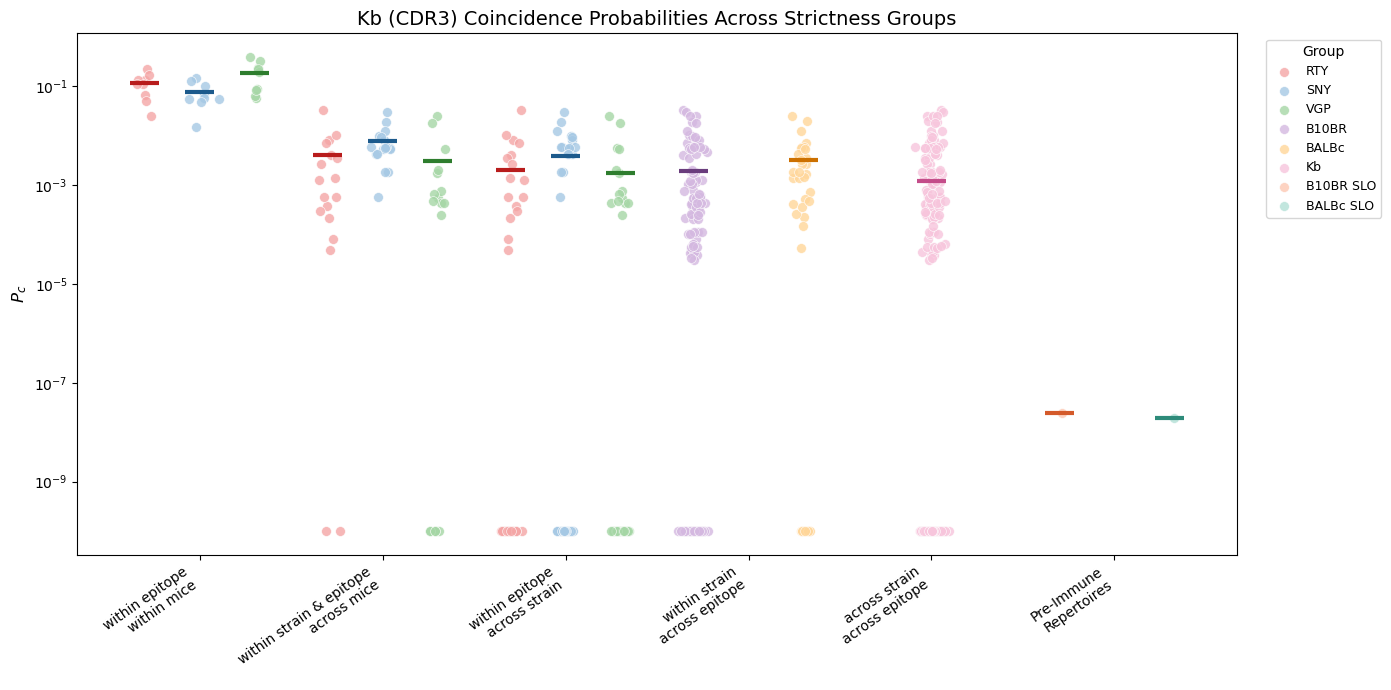

Processing Kd - CDR3
Computing Level 1 for Kd (individual samples)
Computing Level 2 for Kd (individual samples)
Computing Level 3 for Kd (individual samples: within epitope, across strain)
Computing Level 4 for Kd (individual samples: within strain, across epitope)
Computing Level 5 for Kd (individual samples: across strain, across epitope)
Computing Level 6 (Pre-Immune Repertoires) for Kd

Kd pc DataFrame shape: (749, 9)
Level
Pre-Immune\nRepertoires                   2
across strain\nacross epitope           351
within epitope\nacross strain           135
within epitope\nwithin mice              27
within strain\nacross epitope           171
within strain & epitope\nacross mice     63
dtype: int64
Saved: Final_Figures_and_Sheets_Singleset/Kd_strictness_pc_CDR3.svg


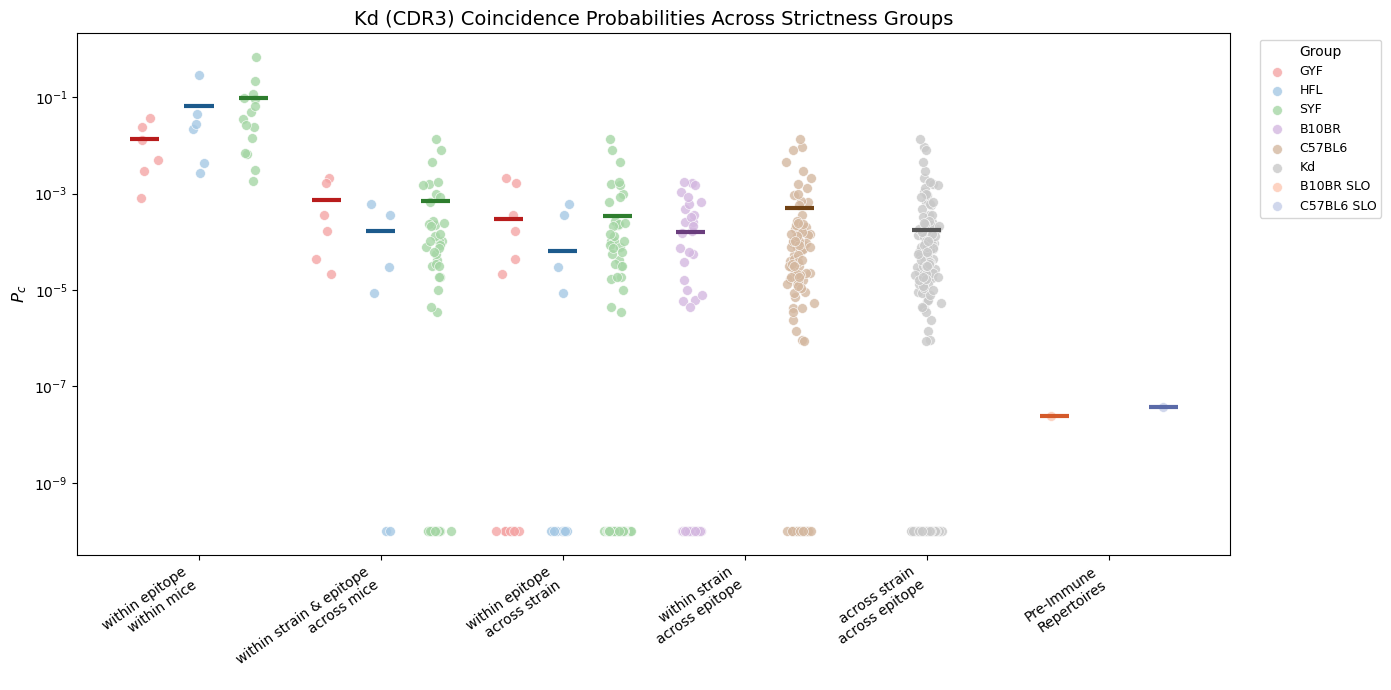

Processing CDR3a

Loading Sanger data
Loading Rhapsody data
  Loading Balbc-B10BR HTxA Kd-SYF HIL
  Loading Balbc-B10BR HTxB Kd-SYF HIL
  Loading Balbc-B10BR HTxC Kd-SYF HIL
  Loading B6Kd-C57BL6 SkTxA Kd-SYF LL
  Loading B6Kd-C57BL6 SkTxB Kd-SYF LL
  Loading B6Kd-C57BL6 SkTxC Kd-SYF LL
  Loading B6Kd-C57BL6 SkTxD Kd-GYF LL
  Loading B6Kd-C57BL6 SkTxE Kd-GYF LL
  Loading B6Kd-C57BL6 SkTxF Kd-GYF LL
  Loading B6Kd-C57BL6 SkTxG Kd-HFL LL
  Loading B6Kd-C57BL6 SkTxH Kd-HFL LL
  Loading B6Kd-C57BL6 SkTxI Kd-HFL LL
  Loading Balbc-C57BL6 HTxA Kd-SYF HIL
  Loading Balbc-C57BL6 HTxB Kd-SYF HIL
  Loading Balbc-C57BL6 HTxC Kd-SYF HIL
  Loading B10BR SLO
  Loading BALBc SLO
  Loading C57BL6 SLO

Building Kb sample dictionary
  Found 27 Kb samples

Building Kd sample dictionary
  Found 27 Kd samples
Processing Kb - CDR3a
Computing Level 1 for Kb (individual samples)
Computing Level 2 for Kb (individual samples)
Computing Level 3 for Kb (individual samples: within epitope, across strain)
Computing

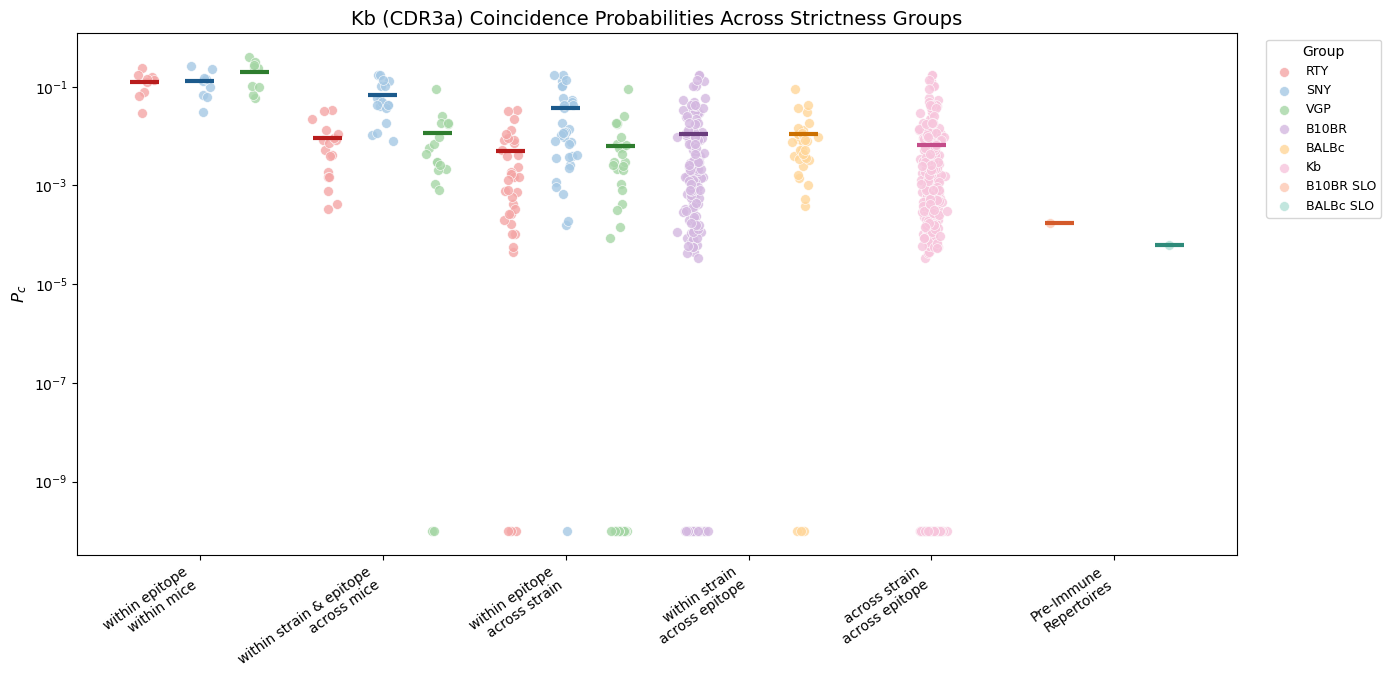

Processing Kd - CDR3a
Computing Level 1 for Kd (individual samples)
Computing Level 2 for Kd (individual samples)
Computing Level 3 for Kd (individual samples: within epitope, across strain)
Computing Level 4 for Kd (individual samples: within strain, across epitope)
Computing Level 5 for Kd (individual samples: across strain, across epitope)
Computing Level 6 (Pre-Immune Repertoires) for Kd

Kd pc DataFrame shape: (749, 9)
Level
Pre-Immune\nRepertoires                   2
across strain\nacross epitope           351
within epitope\nacross strain           135
within epitope\nwithin mice              27
within strain\nacross epitope           171
within strain & epitope\nacross mice     63
dtype: int64
Saved: Final_Figures_and_Sheets_Singleset/Kd_strictness_pc_CDR3a.svg


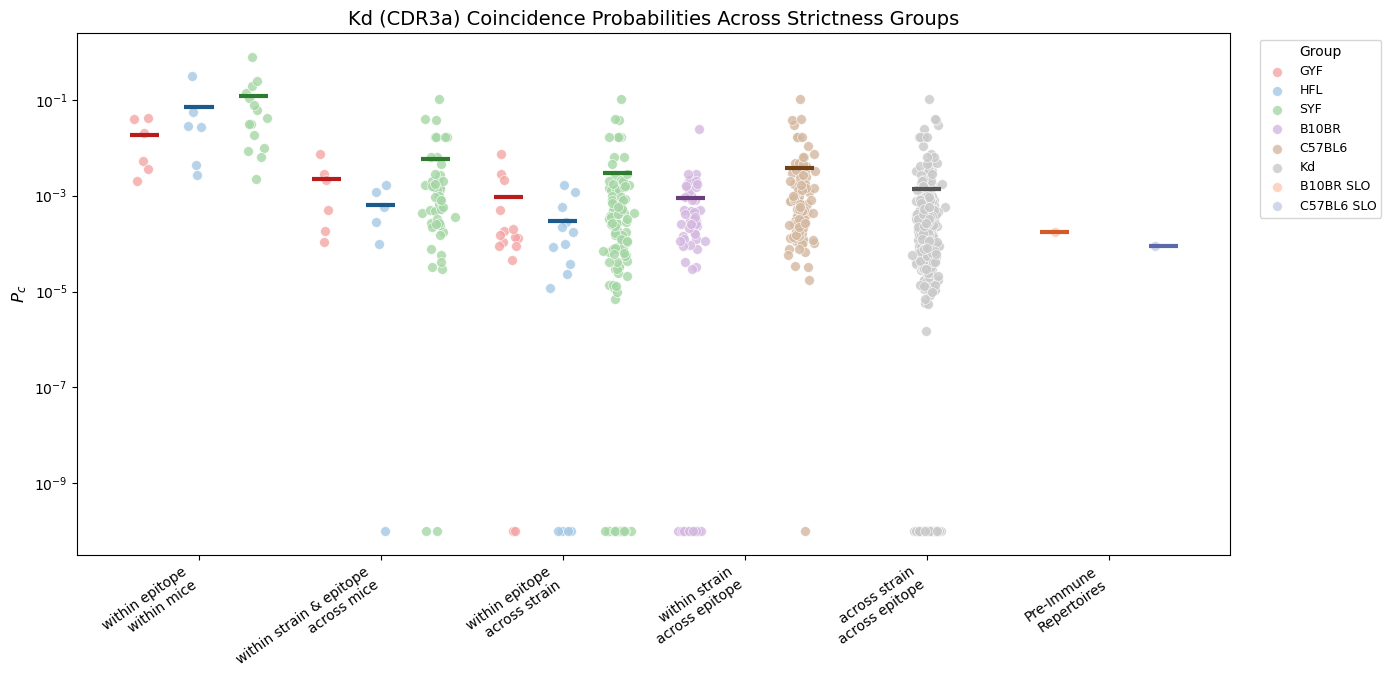

Processing CDR3b

Loading Sanger data
Loading Rhapsody data
  Loading Balbc-B10BR HTxA Kd-SYF HIL
  Loading Balbc-B10BR HTxB Kd-SYF HIL
  Loading Balbc-B10BR HTxC Kd-SYF HIL
  Loading B6Kd-C57BL6 SkTxA Kd-SYF LL
  Loading B6Kd-C57BL6 SkTxB Kd-SYF LL
  Loading B6Kd-C57BL6 SkTxC Kd-SYF LL
  Loading B6Kd-C57BL6 SkTxD Kd-GYF LL
  Loading B6Kd-C57BL6 SkTxE Kd-GYF LL
  Loading B6Kd-C57BL6 SkTxF Kd-GYF LL
  Loading B6Kd-C57BL6 SkTxG Kd-HFL LL
  Loading B6Kd-C57BL6 SkTxH Kd-HFL LL
  Loading B6Kd-C57BL6 SkTxI Kd-HFL LL
  Loading Balbc-C57BL6 HTxA Kd-SYF HIL
  Loading Balbc-C57BL6 HTxB Kd-SYF HIL
  Loading Balbc-C57BL6 HTxC Kd-SYF HIL
  Loading B10BR SLO
  Loading BALBc SLO
  Loading C57BL6 SLO

Building Kb sample dictionary
  Found 27 Kb samples

Building Kd sample dictionary
  Found 27 Kd samples
Processing Kb - CDR3b
Computing Level 1 for Kb (individual samples)
Computing Level 2 for Kb (individual samples)
Computing Level 3 for Kb (individual samples: within epitope, across strain)
Computing

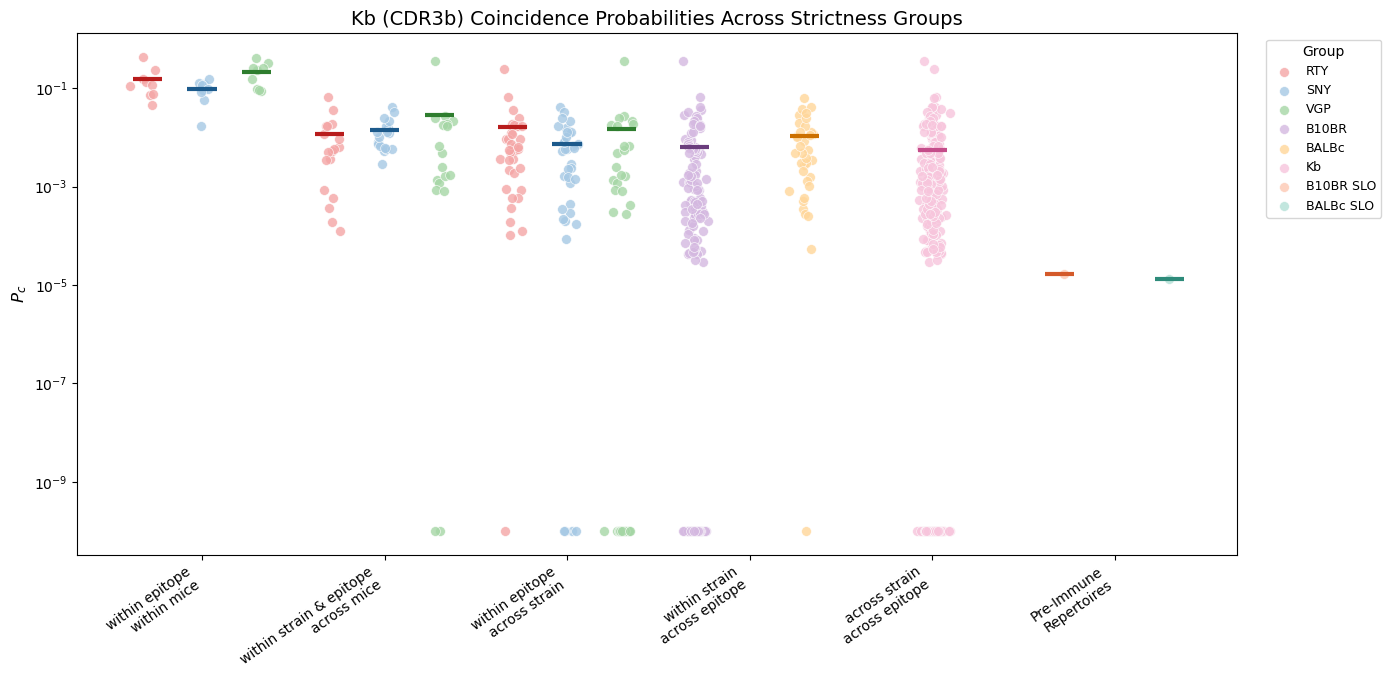

Processing Kd - CDR3b
Computing Level 1 for Kd (individual samples)
Computing Level 2 for Kd (individual samples)
Computing Level 3 for Kd (individual samples: within epitope, across strain)
Computing Level 4 for Kd (individual samples: within strain, across epitope)
Computing Level 5 for Kd (individual samples: across strain, across epitope)
Computing Level 6 (Pre-Immune Repertoires) for Kd

Kd pc DataFrame shape: (749, 9)
Level
Pre-Immune\nRepertoires                   2
across strain\nacross epitope           351
within epitope\nacross strain           135
within epitope\nwithin mice              27
within strain\nacross epitope           171
within strain & epitope\nacross mice     63
dtype: int64
Saved: Final_Figures_and_Sheets_Singleset/Kd_strictness_pc_CDR3b.svg


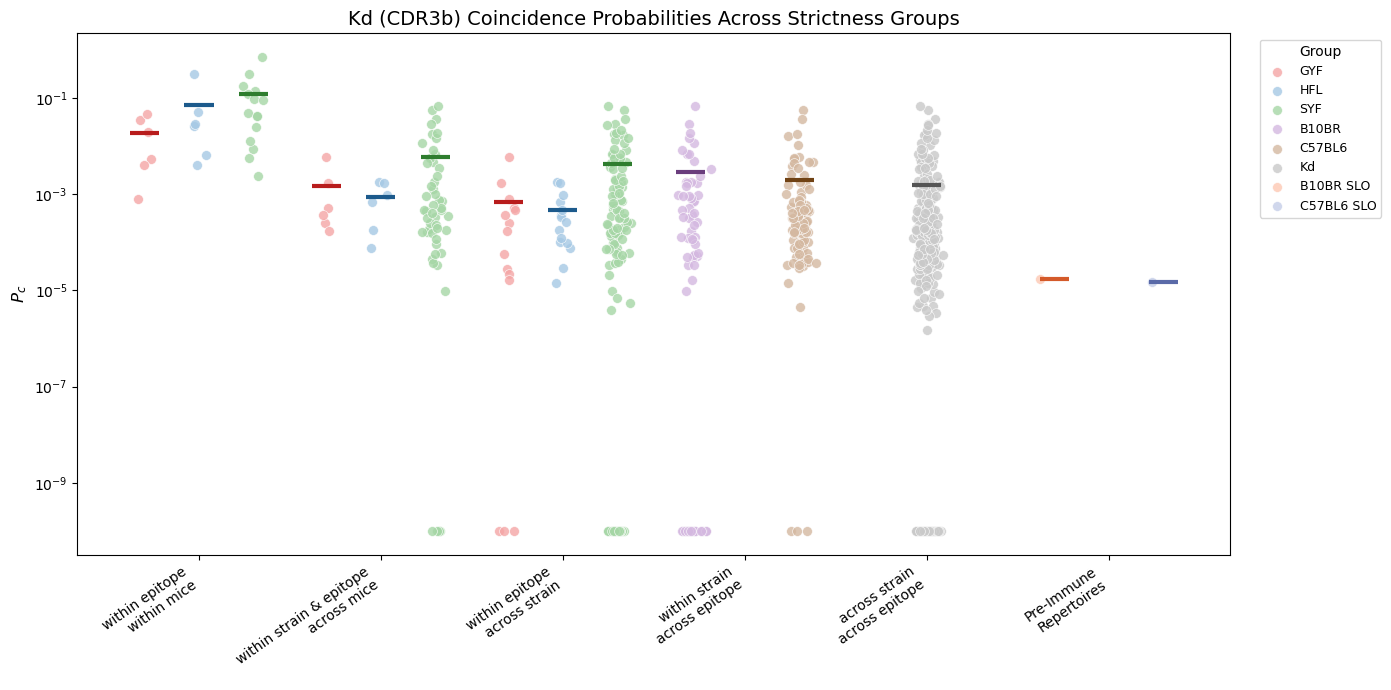

Processing FullChain

Loading Sanger data
Loading Rhapsody data
  Loading Balbc-B10BR HTxA Kd-SYF HIL
  Loading Balbc-B10BR HTxB Kd-SYF HIL
  Loading Balbc-B10BR HTxC Kd-SYF HIL
  Loading B6Kd-C57BL6 SkTxA Kd-SYF LL
  Loading B6Kd-C57BL6 SkTxB Kd-SYF LL
  Loading B6Kd-C57BL6 SkTxC Kd-SYF LL
  Loading B6Kd-C57BL6 SkTxD Kd-GYF LL
  Loading B6Kd-C57BL6 SkTxE Kd-GYF LL
  Loading B6Kd-C57BL6 SkTxF Kd-GYF LL
  Loading B6Kd-C57BL6 SkTxG Kd-HFL LL
  Loading B6Kd-C57BL6 SkTxH Kd-HFL LL
  Loading B6Kd-C57BL6 SkTxI Kd-HFL LL
  Loading Balbc-C57BL6 HTxA Kd-SYF HIL
  Loading Balbc-C57BL6 HTxB Kd-SYF HIL
  Loading Balbc-C57BL6 HTxC Kd-SYF HIL
  Loading B10BR SLO
  Loading BALBc SLO
  Loading C57BL6 SLO

Building Kb sample dictionary
  Found 27 Kb samples

Building Kd sample dictionary
  Found 27 Kd samples
Processing Kb - FullChain
Computing Level 1 for Kb (individual samples)
Computing Level 2 for Kb (individual samples)
Computing Level 3 for Kb (individual samples: within epitope, across strain)
C

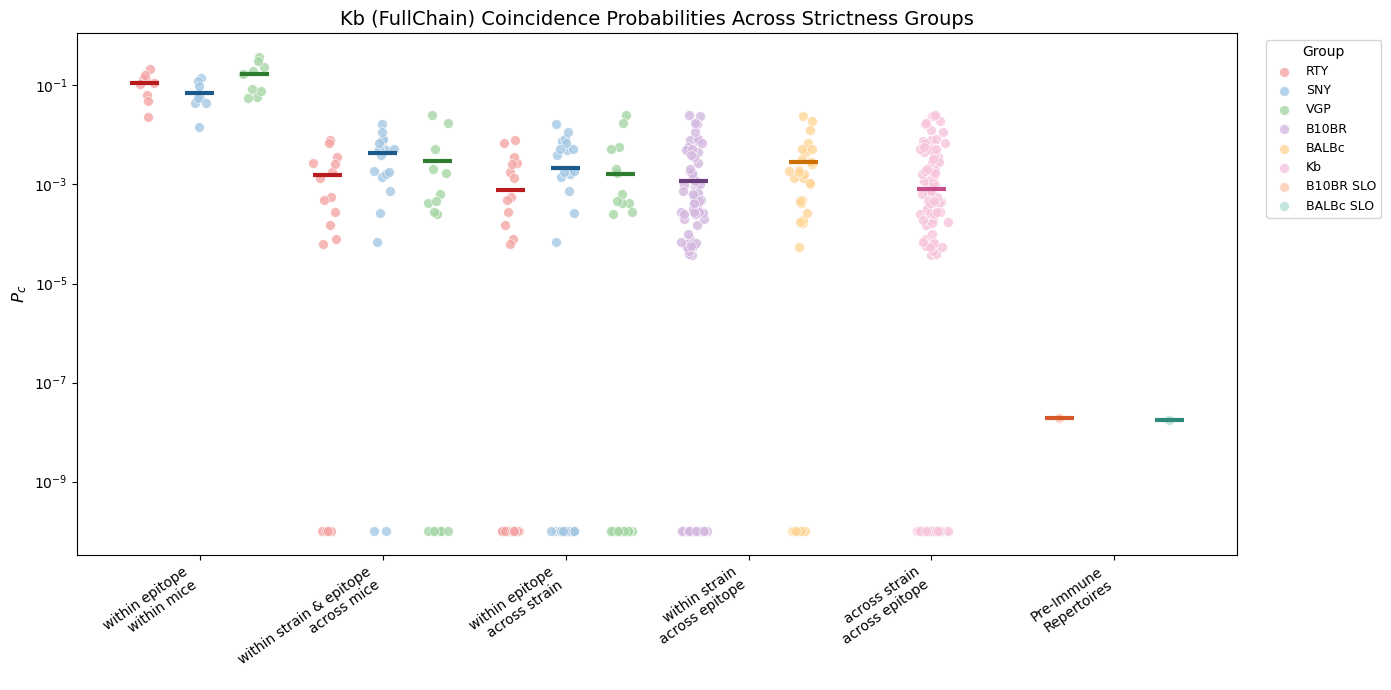

Processing Kd - FullChain
Computing Level 1 for Kd (individual samples)
Computing Level 2 for Kd (individual samples)
Computing Level 3 for Kd (individual samples: within epitope, across strain)
Computing Level 4 for Kd (individual samples: within strain, across epitope)
Computing Level 5 for Kd (individual samples: across strain, across epitope)
Computing Level 6 (Pre-Immune Repertoires) for Kd

Kd pc DataFrame shape: (749, 9)
Level
Pre-Immune\nRepertoires                   2
across strain\nacross epitope           351
within epitope\nacross strain           135
within epitope\nwithin mice              27
within strain\nacross epitope           171
within strain & epitope\nacross mice     63
dtype: int64
Saved: Final_Figures_and_Sheets_Singleset/Kd_strictness_pc_FullChain.svg


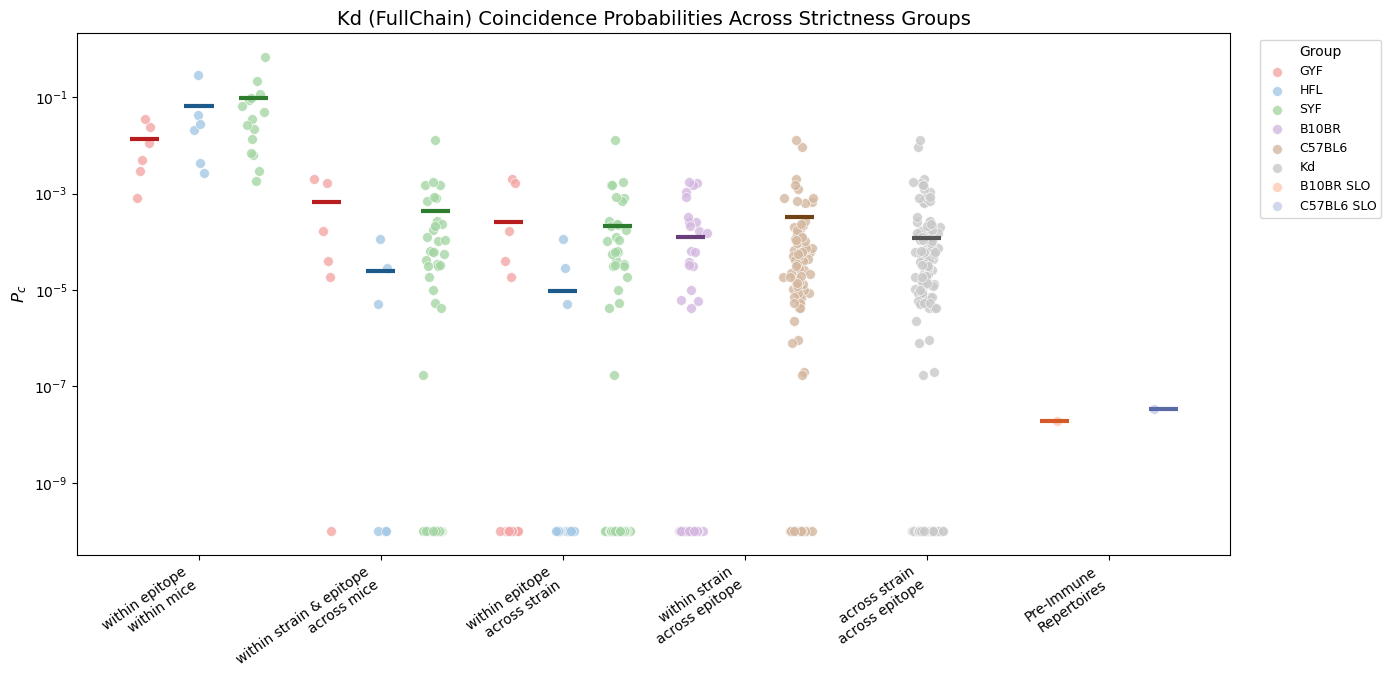

Processing FullAlpha

Loading Sanger data
Loading Rhapsody data
  Loading Balbc-B10BR HTxA Kd-SYF HIL
  Loading Balbc-B10BR HTxB Kd-SYF HIL
  Loading Balbc-B10BR HTxC Kd-SYF HIL
  Loading B6Kd-C57BL6 SkTxA Kd-SYF LL
  Loading B6Kd-C57BL6 SkTxB Kd-SYF LL
  Loading B6Kd-C57BL6 SkTxC Kd-SYF LL
  Loading B6Kd-C57BL6 SkTxD Kd-GYF LL
  Loading B6Kd-C57BL6 SkTxE Kd-GYF LL
  Loading B6Kd-C57BL6 SkTxF Kd-GYF LL
  Loading B6Kd-C57BL6 SkTxG Kd-HFL LL
  Loading B6Kd-C57BL6 SkTxH Kd-HFL LL
  Loading B6Kd-C57BL6 SkTxI Kd-HFL LL
  Loading Balbc-C57BL6 HTxA Kd-SYF HIL
  Loading Balbc-C57BL6 HTxB Kd-SYF HIL
  Loading Balbc-C57BL6 HTxC Kd-SYF HIL
  Loading B10BR SLO
  Loading BALBc SLO
  Loading C57BL6 SLO

Building Kb sample dictionary
  Found 27 Kb samples

Building Kd sample dictionary
  Found 27 Kd samples
Processing Kb - FullAlpha
Computing Level 1 for Kb (individual samples)
Computing Level 2 for Kb (individual samples)
Computing Level 3 for Kb (individual samples: within epitope, across strain)
C

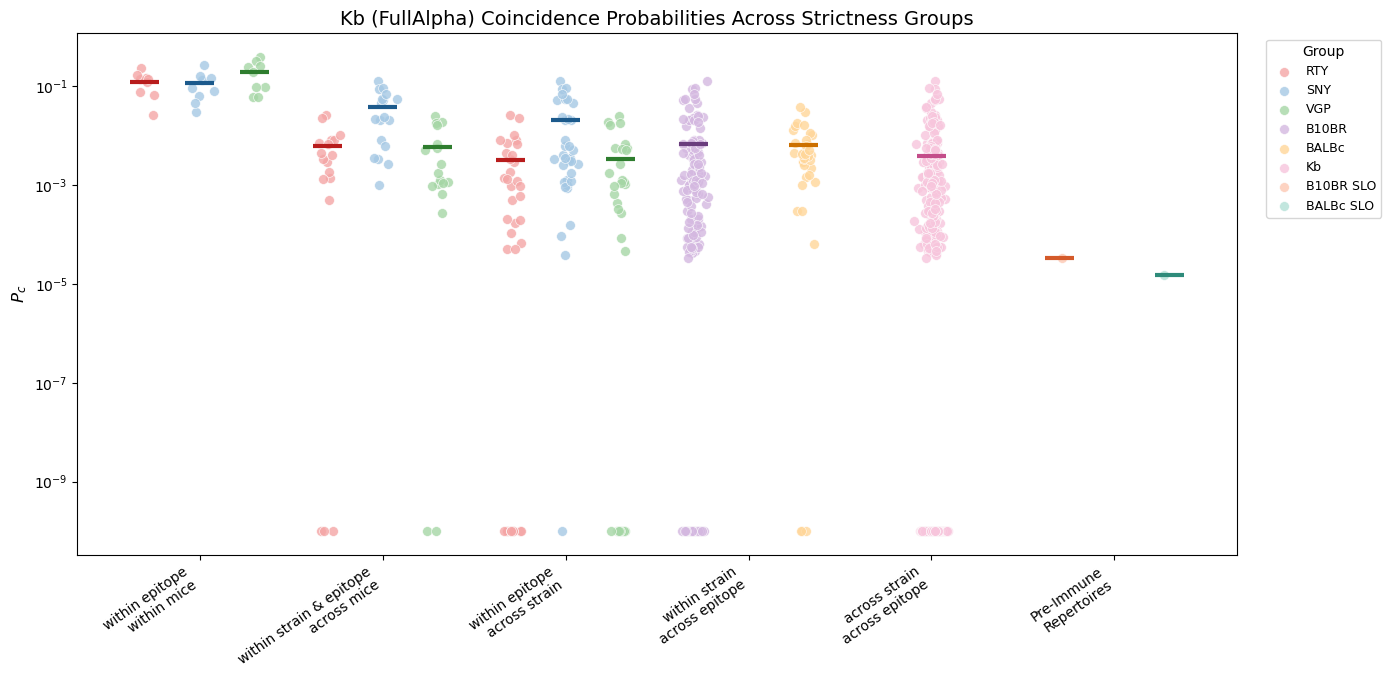

Processing Kd - FullAlpha
Computing Level 1 for Kd (individual samples)
Computing Level 2 for Kd (individual samples)
Computing Level 3 for Kd (individual samples: within epitope, across strain)
Computing Level 4 for Kd (individual samples: within strain, across epitope)
Computing Level 5 for Kd (individual samples: across strain, across epitope)
Computing Level 6 (Pre-Immune Repertoires) for Kd

Kd pc DataFrame shape: (749, 9)
Level
Pre-Immune\nRepertoires                   2
across strain\nacross epitope           351
within epitope\nacross strain           135
within epitope\nwithin mice              27
within strain\nacross epitope           171
within strain & epitope\nacross mice     63
dtype: int64
Saved: Final_Figures_and_Sheets_Singleset/Kd_strictness_pc_FullAlpha.svg


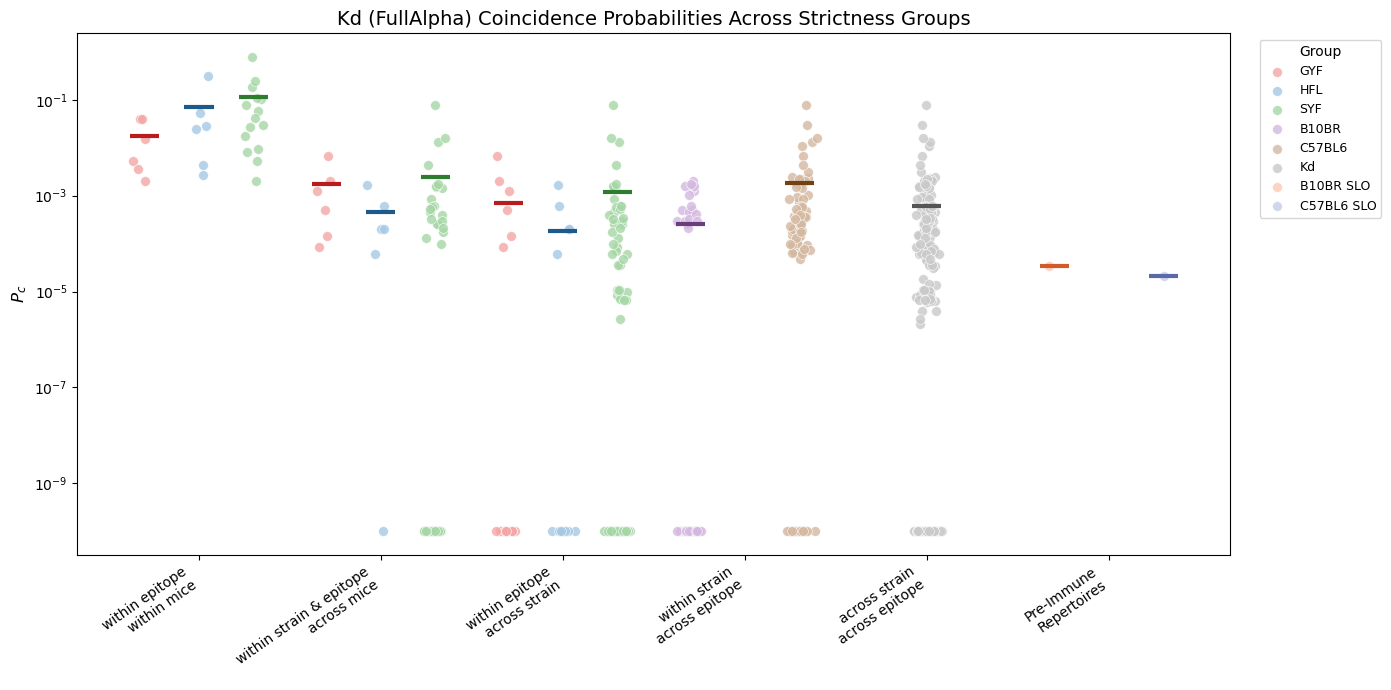

Processing FullBeta

Loading Sanger data
Loading Rhapsody data
  Loading Balbc-B10BR HTxA Kd-SYF HIL
  Loading Balbc-B10BR HTxB Kd-SYF HIL
  Loading Balbc-B10BR HTxC Kd-SYF HIL
  Loading B6Kd-C57BL6 SkTxA Kd-SYF LL
  Loading B6Kd-C57BL6 SkTxB Kd-SYF LL
  Loading B6Kd-C57BL6 SkTxC Kd-SYF LL
  Loading B6Kd-C57BL6 SkTxD Kd-GYF LL
  Loading B6Kd-C57BL6 SkTxE Kd-GYF LL
  Loading B6Kd-C57BL6 SkTxF Kd-GYF LL
  Loading B6Kd-C57BL6 SkTxG Kd-HFL LL
  Loading B6Kd-C57BL6 SkTxH Kd-HFL LL
  Loading B6Kd-C57BL6 SkTxI Kd-HFL LL
  Loading Balbc-C57BL6 HTxA Kd-SYF HIL
  Loading Balbc-C57BL6 HTxB Kd-SYF HIL
  Loading Balbc-C57BL6 HTxC Kd-SYF HIL
  Loading B10BR SLO
  Loading BALBc SLO
  Loading C57BL6 SLO

Building Kb sample dictionary
  Found 27 Kb samples

Building Kd sample dictionary
  Found 27 Kd samples
Processing Kb - FullBeta
Computing Level 1 for Kb (individual samples)
Computing Level 2 for Kb (individual samples)
Computing Level 3 for Kb (individual samples: within epitope, across strain)
Com

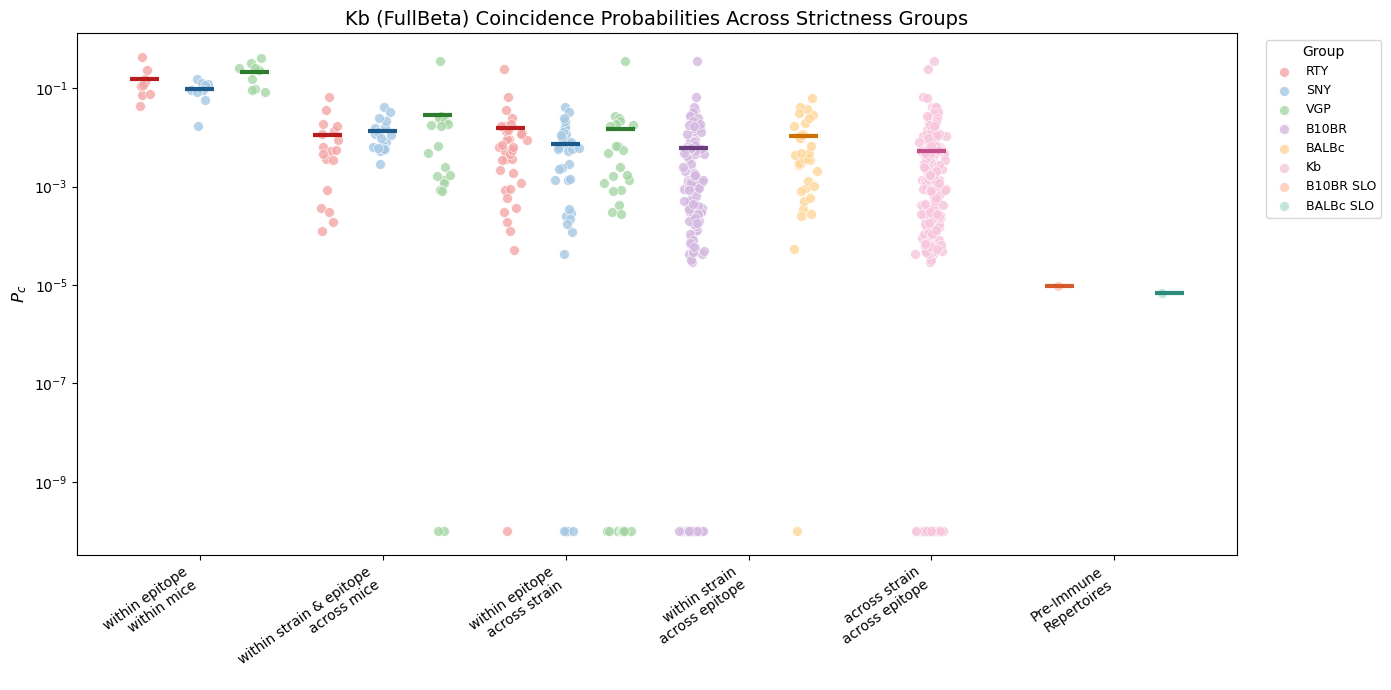

Processing Kd - FullBeta
Computing Level 1 for Kd (individual samples)
Computing Level 2 for Kd (individual samples)
Computing Level 3 for Kd (individual samples: within epitope, across strain)
Computing Level 4 for Kd (individual samples: within strain, across epitope)
Computing Level 5 for Kd (individual samples: across strain, across epitope)
Computing Level 6 (Pre-Immune Repertoires) for Kd

Kd pc DataFrame shape: (749, 9)
Level
Pre-Immune\nRepertoires                   2
across strain\nacross epitope           351
within epitope\nacross strain           135
within epitope\nwithin mice              27
within strain\nacross epitope           171
within strain & epitope\nacross mice     63
dtype: int64
Saved: Final_Figures_and_Sheets_Singleset/Kd_strictness_pc_FullBeta.svg


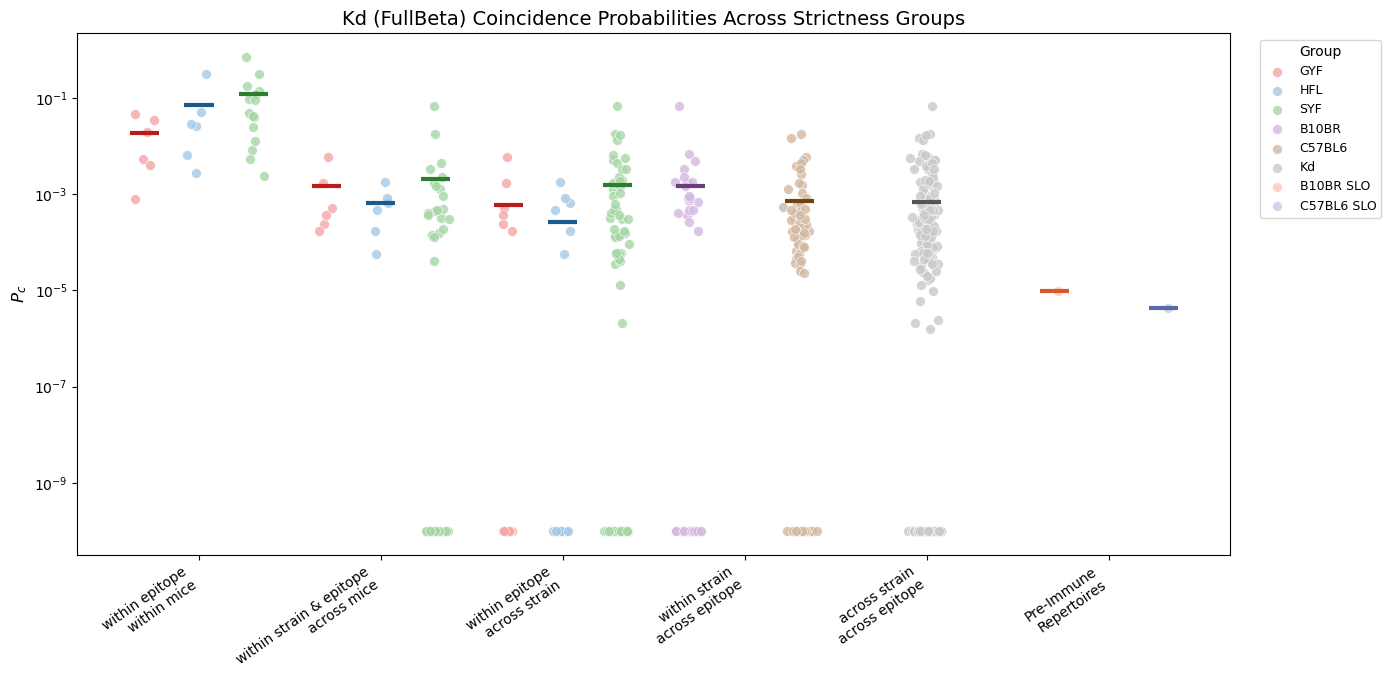

SUMMARY: Average Pc and Ratios Between Levels

Kb - CDR3:
                              Level  N_Values      Mean_pc Fold_Change Fold_vs_Level1
         within epitope within mice        27 1.233961e-01           -         1.000x
within strain & epitope across mice        54 4.962322e-03      0.040x         0.040x
       within epitope across strain       108 2.536920e-03      0.511x         0.021x
       within strain across epitope       189 2.160848e-03      0.852x         0.018x
       across strain across epitope       351 1.180690e-03      0.546x         0.010x
             Pre-Immune Repertoires         2 2.185435e-08      0.000x         0.000x

Kb - CDR3a:
                              Level  N_Values  Mean_pc Fold_Change Fold_vs_Level1
         within epitope within mice        27 0.153521           -         1.000x
within strain & epitope across mice        54 0.029739      0.194x         0.194x
       within epitope across strain       108 0.015909      0.535x         0.104x

In [111]:
if __name__ == "__main__":
    results = main()